In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm import tqdm

# if missing, install with pip install easydict
from easydict import EasyDict as edict

/export/scratch/ra23mar/miniconda3/envs/3d/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

### Config

In [4]:
args = edict()
args.cuda = torch.cuda.is_available()
args.test_batch_size = 10
args.batch_size = 128
args.lr = 0.001
args.momentum = 1e-5
args.log_interval = 100
args.epochs = 101
# switch between denoising (True) and plain autoencoder (False)
args.is_noisy = False

### Functions and Classes

In [5]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [6]:
def to_img(x, shape=(28, 28)):
    x = 0.5 * (x + 1) # move to range [0, 1]
    x = x.clamp(0, 1) # clip boundaries
    x = x.view(x.size(0), 1, shape[0], shape[1]) # reshape
    return x

### Data Preparation

In [7]:
train_mean, train_std = (0.5,), (0.5,)
train_loader = DataLoader(
    datasets.FashionMNIST('./data_fmnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(train_mean, train_std)  
                   ])),
    batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(
    datasets.FashionMNIST('./data_fmnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(train_mean, train_std)  
                   ])),
    batch_size=args.test_batch_size, shuffle=False)

In [8]:
def add_white_noise(x, factor=0.5, stddev=1):
    # add white noise to tensor
    noise = x.clone().normal_(0, stddev)
    return x + noise * factor

class AddWhiteNoise(object):
    def __init__(self, stddev=1, noise_factor=0.5):
        self.stddev = stddev
        self.factor = noise_factor

    def __call__(self, tensor):
        """ add white noise to tensor 
        (this needs to be done before normalization!)
        
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """   
        tensor = add_white_noise(tensor, factor=self.factor, stddev=self.stddev)
        return tensor.clamp_(0, 1) # clip boundaries to range [0, 1]

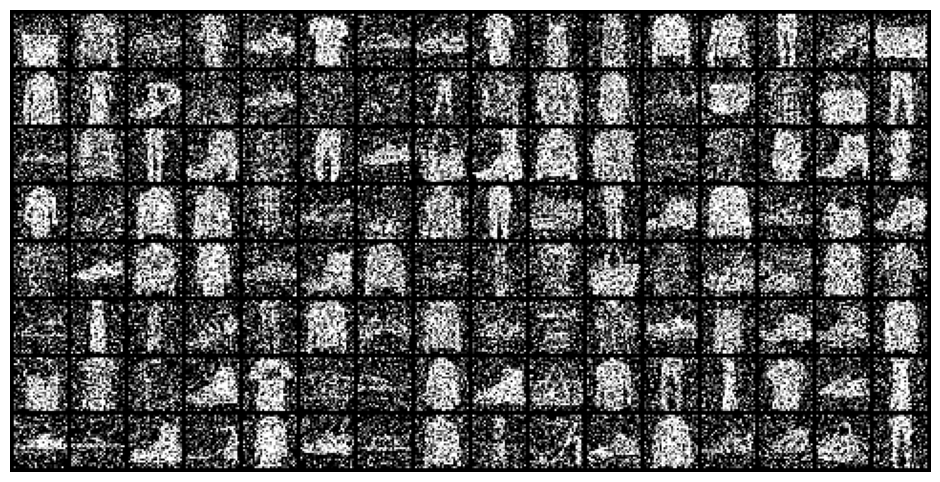

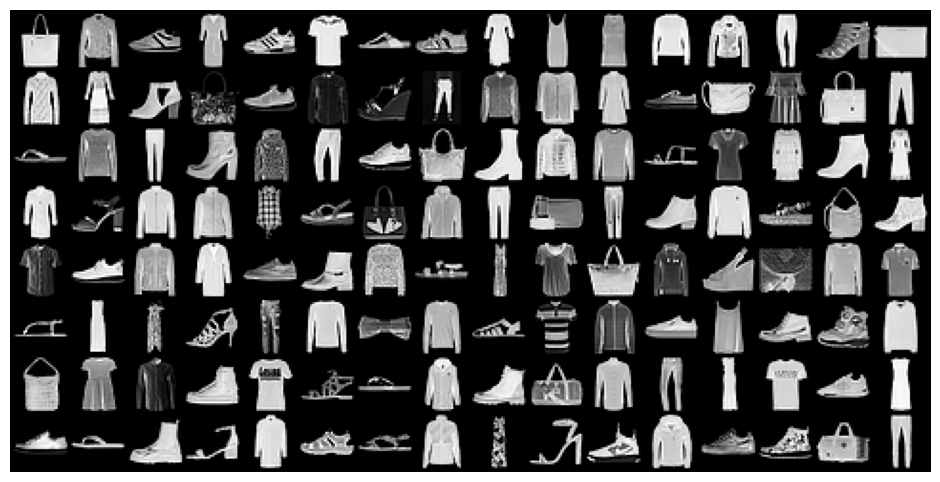

In [9]:
# display a batch using make grid
in_img = next(iter(train_loader))[0]
inputs = torch.stack([UnNormalize(train_mean, train_std)(in_img[i]) for i in range(in_img.shape[0])])
noisy_inputs = AddWhiteNoise(noise_factor=0.5)(inputs.clone())
plt.imshow(transforms.ToPILImage()(make_grid(noisy_inputs, nrow=16)))
plt.axis('off')
plt.show()
plt.imshow(transforms.ToPILImage()(make_grid(inputs, nrow=16)))
plt.axis('off')
plt.show()

# Task 1 Linear AE

In [15]:
class Autoencoder(nn.Module):
    def __init__(self, input_shape=(28, 28)):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(np.prod(input_shape), 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, 8),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 8),  #(8, 16)
            nn.ReLU(True),
            nn.Linear(8, 32), #(16, 32)
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, np.prod(input_shape)), 
            nn.Tanh(), # mapping output to -1, 1 range
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

In [16]:
# create the model and move to GPU if available
model = Autoencoder()
if args.cuda:
    model.to(torch.device('cuda'))

# initialize the optimzation algorithm
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.momentum)

# use mean squared error loss as reconstruction loss
criterion = nn.MSELoss()

In [17]:
# define train loop
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # reshape to vector
        data = data.view(data.size(0), -1)
        # move to cuda if available
        if args.cuda:
            data = data.to(device=torch.device('cuda'))
        # add noise
        if args.is_noisy:
            data_in = add_white_noise(data.clone())
            data_in.clamp_(-train_mean[0]/train_std[0], (1-train_mean[0])/train_std[0])
        else:
            data_in = data
        # forward: evaluate with model
        output = model(data_in)
        loss = criterion(output, data)
        # backward: compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# define test loop
def test(show_plot=False):
    model.eval()
    test_loss = 0
    for i, (data, target) in enumerate(test_loader):
        # reshape to vector
        data = data.view(data.size(0), -1)
        # move to cuda if available
        if args.cuda:
            data = data.cuda()
        # add noise
        if args.is_noisy:
            data_in = add_white_noise(data.clone())
            data_in.clamp_(-train_mean[0]/train_std[0], (1-train_mean[0])/train_std[0])
        else:
            data_in = data
        # forward: evaluate with model
        output = model(data_in)
        test_loss += nn.MSELoss(size_average=False)(output, data).item() # sum up batch loss
        
        if show_plot == 1 and i == 0:
            inp = make_grid(to_img(data_in.cpu().data))
            out = make_grid(to_img(output.cpu().data))
            target = make_grid(to_img(data.cpu().data))
            if args.is_noisy:
                plt.imshow(transforms.ToPILImage()(inp))
                plt.axis('off')
                plt.show()
            plt.imshow(transforms.ToPILImage()(out))
            plt.axis('off')
            plt.show()
            plt.imshow(transforms.ToPILImage()(target))
            plt.axis('off')
            plt.show()
        
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
        
    return test_loss

/export/scratch/ra23mar/miniconda3/envs/3d/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


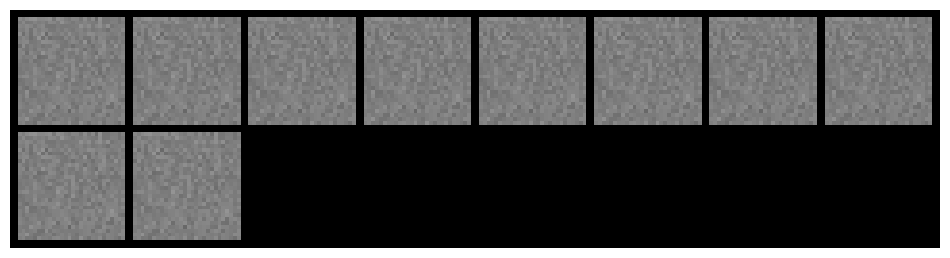

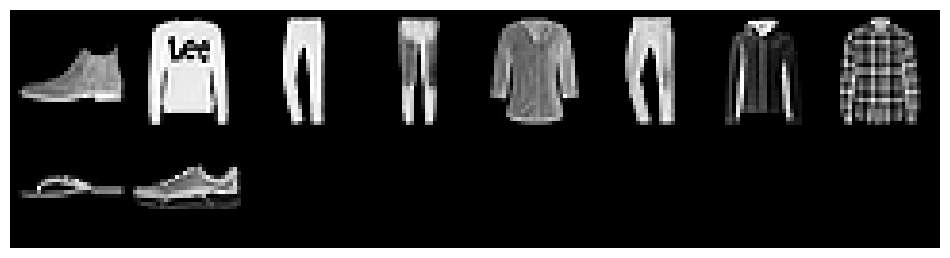


Test set: Average loss: 534.1575

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.685696
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.227599
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.163172
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.132711
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.136820


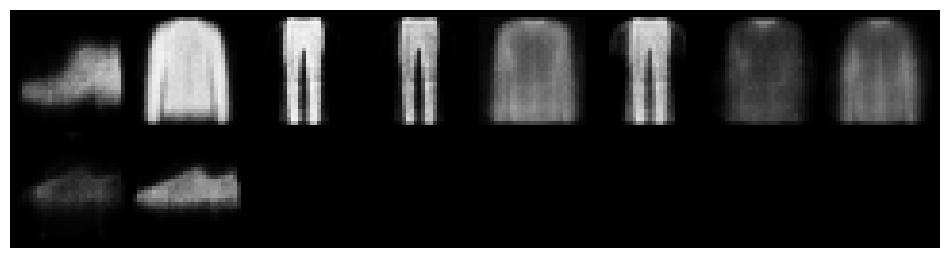

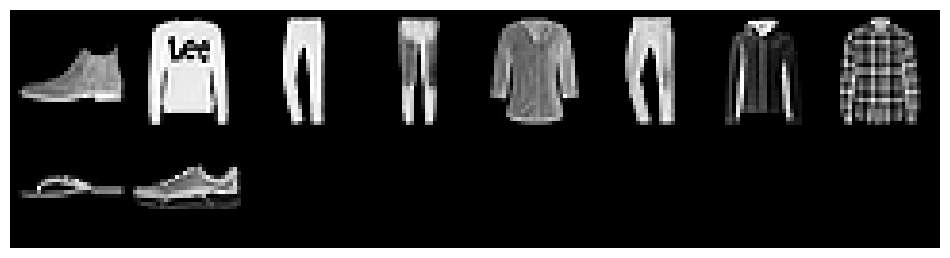


Test set: Average loss: 97.0783

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.129533
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.121807
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.111283
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.107290
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.107358

Test set: Average loss: 86.8267

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.115616
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.100028
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.106065
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.104933
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.115430

Test set: Average loss: 79.7922

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.102698
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.110376
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.099127
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.093283
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.094140

Test set: Average loss: 72.9710

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.091849
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.084932
Train Epoch: 5 [25600/60000 (43%)]

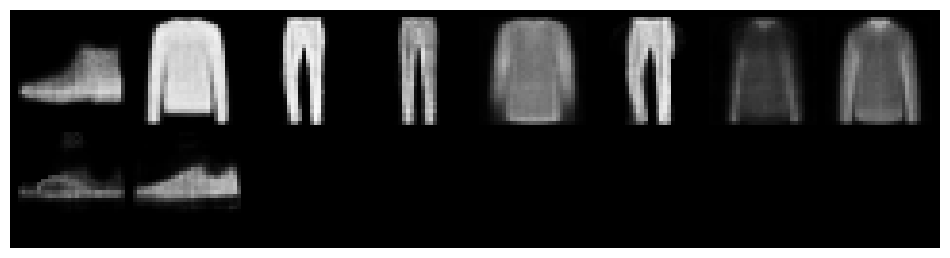

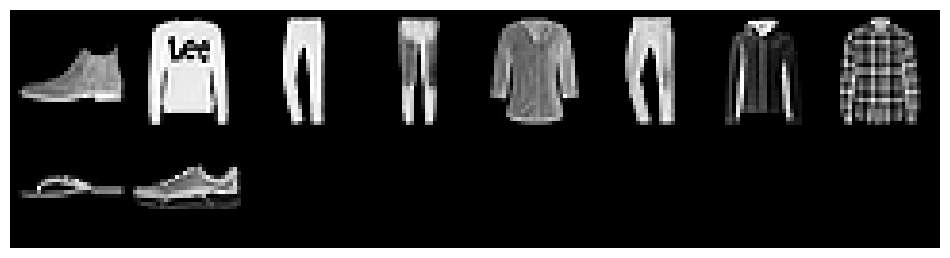


Test set: Average loss: 60.2139

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.082788
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.079859
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.074092
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.074734
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.079280

Test set: Average loss: 59.5845

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.071074
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.079052
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.072688
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.073624
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.081141

Test set: Average loss: 59.8238

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.075801
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.076186
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.065552
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.080640
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.077057

Test set: Average loss: 59.4365

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.067420
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.072550
Train Epoch: 15 [

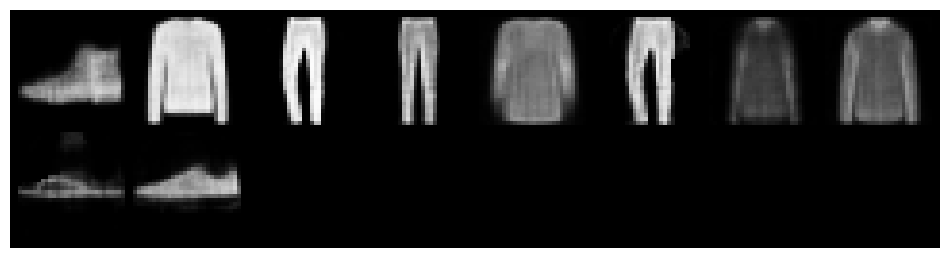

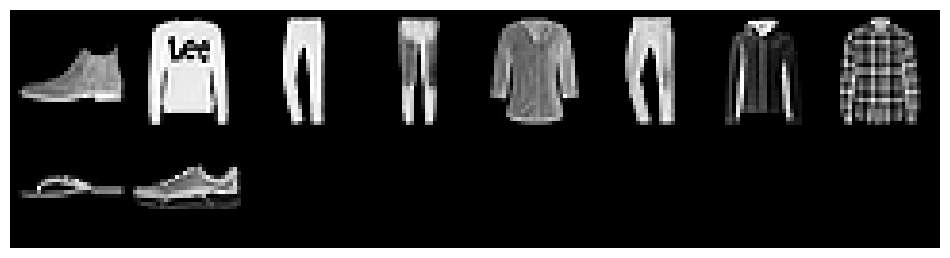


Test set: Average loss: 56.8054

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.069086
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.076085
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.076226
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.074592
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.067547

Test set: Average loss: 56.7272

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.069031
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.071869
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.081649
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.068609
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.075045

Test set: Average loss: 56.7136

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.070827
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.070883
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.075222
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.077255
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.068999

Test set: Average loss: 56.1403

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.077302
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.075023
Train Epoch: 25 [

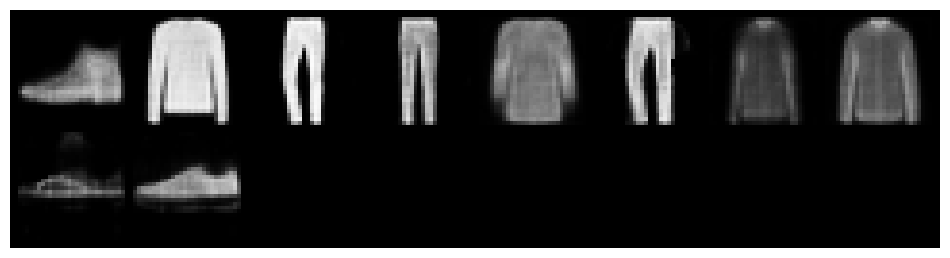

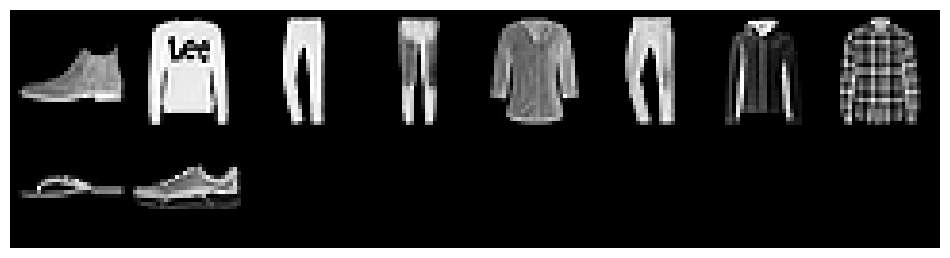


Test set: Average loss: 54.9791

Train Epoch: 32 [0/60000 (0%)]	Loss: 0.074166
Train Epoch: 32 [12800/60000 (21%)]	Loss: 0.077022
Train Epoch: 32 [25600/60000 (43%)]	Loss: 0.066088
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.063750
Train Epoch: 32 [51200/60000 (85%)]	Loss: 0.068924

Test set: Average loss: 54.7490

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.072187
Train Epoch: 33 [12800/60000 (21%)]	Loss: 0.068611
Train Epoch: 33 [25600/60000 (43%)]	Loss: 0.068624
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.070984
Train Epoch: 33 [51200/60000 (85%)]	Loss: 0.065138

Test set: Average loss: 54.4522

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.064057
Train Epoch: 34 [12800/60000 (21%)]	Loss: 0.064296
Train Epoch: 34 [25600/60000 (43%)]	Loss: 0.069352
Train Epoch: 34 [38400/60000 (64%)]	Loss: 0.072343
Train Epoch: 34 [51200/60000 (85%)]	Loss: 0.074538

Test set: Average loss: 54.8957

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.067907
Train Epoch: 35 [12800/60000 (21%)]	Loss: 0.066538
Train Epoch: 35 [

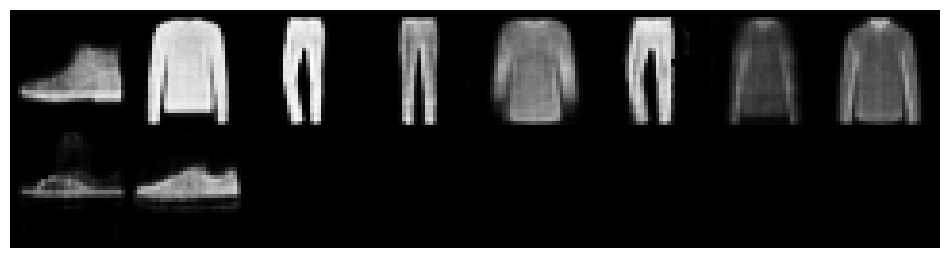

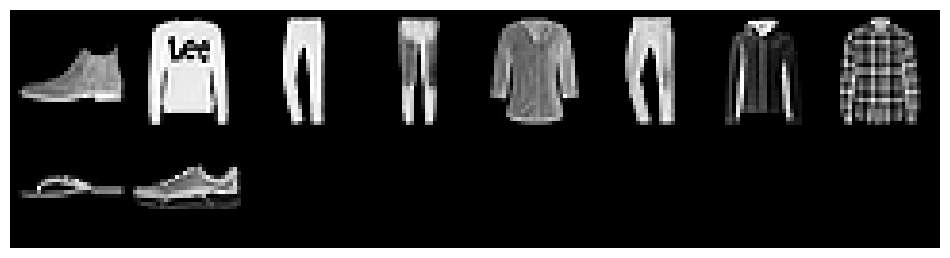


Test set: Average loss: 51.6064

Train Epoch: 42 [0/60000 (0%)]	Loss: 0.071793
Train Epoch: 42 [12800/60000 (21%)]	Loss: 0.069358
Train Epoch: 42 [25600/60000 (43%)]	Loss: 0.072330
Train Epoch: 42 [38400/60000 (64%)]	Loss: 0.061082
Train Epoch: 42 [51200/60000 (85%)]	Loss: 0.064644

Test set: Average loss: 51.4696

Train Epoch: 43 [0/60000 (0%)]	Loss: 0.068192
Train Epoch: 43 [12800/60000 (21%)]	Loss: 0.061714
Train Epoch: 43 [25600/60000 (43%)]	Loss: 0.060262
Train Epoch: 43 [38400/60000 (64%)]	Loss: 0.062839
Train Epoch: 43 [51200/60000 (85%)]	Loss: 0.063673

Test set: Average loss: 51.1666

Train Epoch: 44 [0/60000 (0%)]	Loss: 0.062022
Train Epoch: 44 [12800/60000 (21%)]	Loss: 0.066157
Train Epoch: 44 [25600/60000 (43%)]	Loss: 0.066329
Train Epoch: 44 [38400/60000 (64%)]	Loss: 0.064742
Train Epoch: 44 [51200/60000 (85%)]	Loss: 0.066328

Test set: Average loss: 51.2939

Train Epoch: 45 [0/60000 (0%)]	Loss: 0.069705
Train Epoch: 45 [12800/60000 (21%)]	Loss: 0.065102
Train Epoch: 45 [

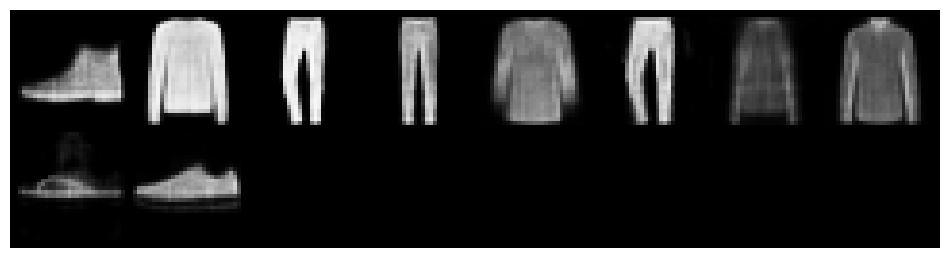

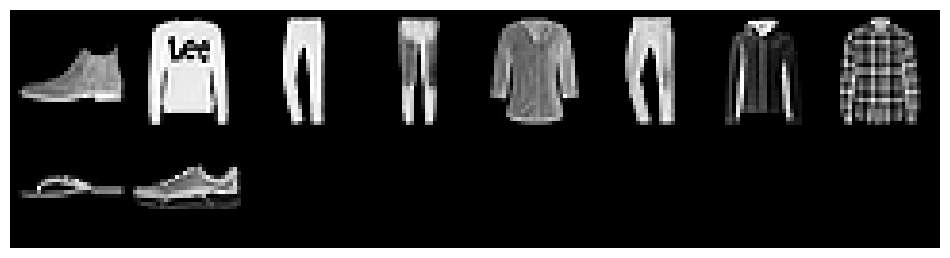


Test set: Average loss: 51.1359

Train Epoch: 52 [0/60000 (0%)]	Loss: 0.063493
Train Epoch: 52 [12800/60000 (21%)]	Loss: 0.067327
Train Epoch: 52 [25600/60000 (43%)]	Loss: 0.060790
Train Epoch: 52 [38400/60000 (64%)]	Loss: 0.065669
Train Epoch: 52 [51200/60000 (85%)]	Loss: 0.073917

Test set: Average loss: 50.7909

Train Epoch: 53 [0/60000 (0%)]	Loss: 0.063901
Train Epoch: 53 [12800/60000 (21%)]	Loss: 0.056862
Train Epoch: 53 [25600/60000 (43%)]	Loss: 0.059373
Train Epoch: 53 [38400/60000 (64%)]	Loss: 0.061794
Train Epoch: 53 [51200/60000 (85%)]	Loss: 0.063288

Test set: Average loss: 50.5859

Train Epoch: 54 [0/60000 (0%)]	Loss: 0.061846
Train Epoch: 54 [12800/60000 (21%)]	Loss: 0.061171
Train Epoch: 54 [25600/60000 (43%)]	Loss: 0.063386
Train Epoch: 54 [38400/60000 (64%)]	Loss: 0.065663
Train Epoch: 54 [51200/60000 (85%)]	Loss: 0.065525

Test set: Average loss: 50.2381

Train Epoch: 55 [0/60000 (0%)]	Loss: 0.054893
Train Epoch: 55 [12800/60000 (21%)]	Loss: 0.060945
Train Epoch: 55 [

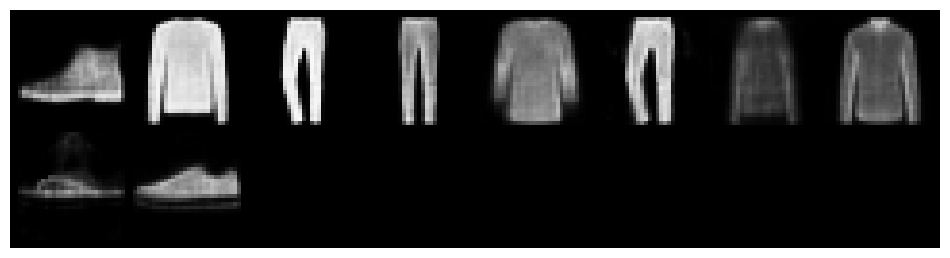

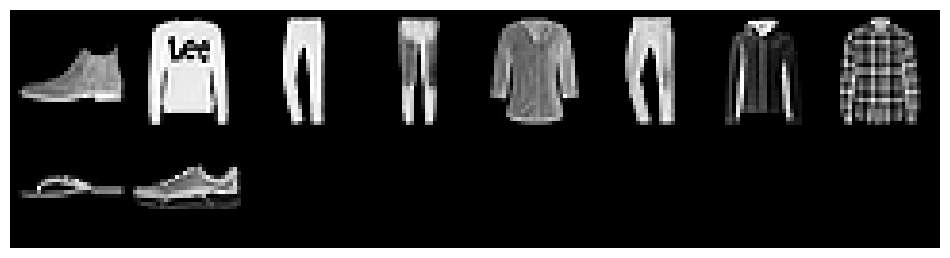


Test set: Average loss: 50.2119

Train Epoch: 62 [0/60000 (0%)]	Loss: 0.065511
Train Epoch: 62 [12800/60000 (21%)]	Loss: 0.061806
Train Epoch: 62 [25600/60000 (43%)]	Loss: 0.059955
Train Epoch: 62 [38400/60000 (64%)]	Loss: 0.059208
Train Epoch: 62 [51200/60000 (85%)]	Loss: 0.058557

Test set: Average loss: 49.8425

Train Epoch: 63 [0/60000 (0%)]	Loss: 0.058967
Train Epoch: 63 [12800/60000 (21%)]	Loss: 0.064392
Train Epoch: 63 [25600/60000 (43%)]	Loss: 0.067219
Train Epoch: 63 [38400/60000 (64%)]	Loss: 0.062705
Train Epoch: 63 [51200/60000 (85%)]	Loss: 0.058922

Test set: Average loss: 50.0090

Train Epoch: 64 [0/60000 (0%)]	Loss: 0.063183
Train Epoch: 64 [12800/60000 (21%)]	Loss: 0.068220
Train Epoch: 64 [25600/60000 (43%)]	Loss: 0.060775
Train Epoch: 64 [38400/60000 (64%)]	Loss: 0.061721
Train Epoch: 64 [51200/60000 (85%)]	Loss: 0.062667

Test set: Average loss: 50.4209

Train Epoch: 65 [0/60000 (0%)]	Loss: 0.062569
Train Epoch: 65 [12800/60000 (21%)]	Loss: 0.065334
Train Epoch: 65 [

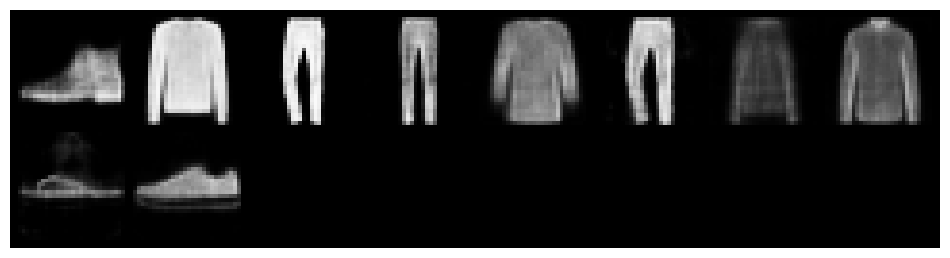

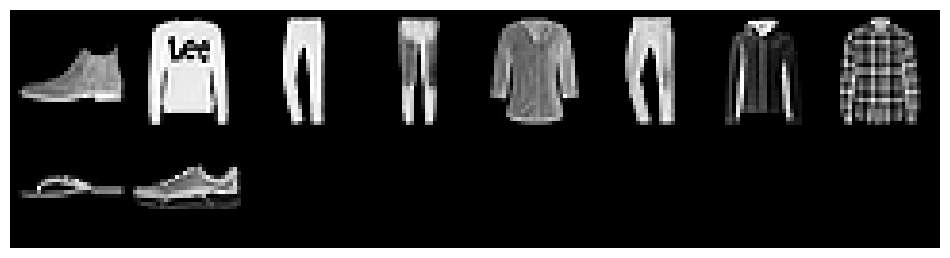


Test set: Average loss: 49.7540

Train Epoch: 72 [0/60000 (0%)]	Loss: 0.066042
Train Epoch: 72 [12800/60000 (21%)]	Loss: 0.072021
Train Epoch: 72 [25600/60000 (43%)]	Loss: 0.058520
Train Epoch: 72 [38400/60000 (64%)]	Loss: 0.059764
Train Epoch: 72 [51200/60000 (85%)]	Loss: 0.061010

Test set: Average loss: 49.5003

Train Epoch: 73 [0/60000 (0%)]	Loss: 0.062340
Train Epoch: 73 [12800/60000 (21%)]	Loss: 0.057756
Train Epoch: 73 [25600/60000 (43%)]	Loss: 0.062622
Train Epoch: 73 [38400/60000 (64%)]	Loss: 0.064874
Train Epoch: 73 [51200/60000 (85%)]	Loss: 0.062317

Test set: Average loss: 49.5725

Train Epoch: 74 [0/60000 (0%)]	Loss: 0.064066
Train Epoch: 74 [12800/60000 (21%)]	Loss: 0.063371
Train Epoch: 74 [25600/60000 (43%)]	Loss: 0.062432
Train Epoch: 74 [38400/60000 (64%)]	Loss: 0.064536
Train Epoch: 74 [51200/60000 (85%)]	Loss: 0.063059

Test set: Average loss: 49.6617

Train Epoch: 75 [0/60000 (0%)]	Loss: 0.056209
Train Epoch: 75 [12800/60000 (21%)]	Loss: 0.060575
Train Epoch: 75 [

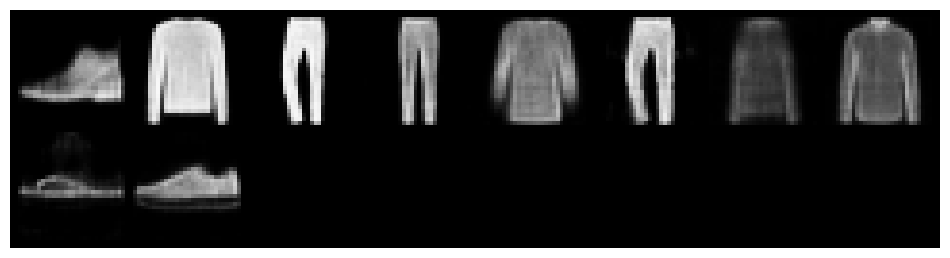

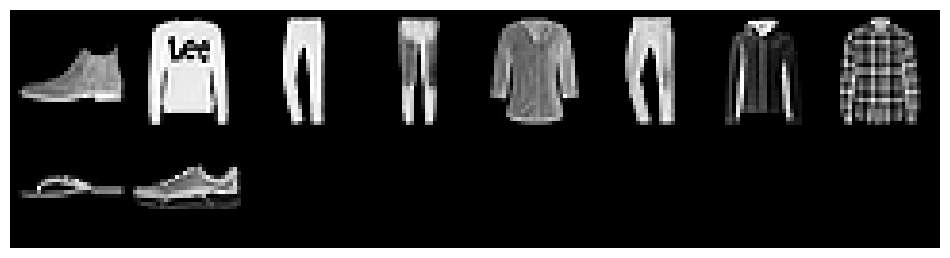


Test set: Average loss: 49.0323

Train Epoch: 82 [0/60000 (0%)]	Loss: 0.060196
Train Epoch: 82 [12800/60000 (21%)]	Loss: 0.056675
Train Epoch: 82 [25600/60000 (43%)]	Loss: 0.066906
Train Epoch: 82 [38400/60000 (64%)]	Loss: 0.059988
Train Epoch: 82 [51200/60000 (85%)]	Loss: 0.057928

Test set: Average loss: 49.5539

Train Epoch: 83 [0/60000 (0%)]	Loss: 0.062489
Train Epoch: 83 [12800/60000 (21%)]	Loss: 0.056257
Train Epoch: 83 [25600/60000 (43%)]	Loss: 0.066784
Train Epoch: 83 [38400/60000 (64%)]	Loss: 0.066653
Train Epoch: 83 [51200/60000 (85%)]	Loss: 0.061835

Test set: Average loss: 49.5294

Train Epoch: 84 [0/60000 (0%)]	Loss: 0.057781
Train Epoch: 84 [12800/60000 (21%)]	Loss: 0.057296
Train Epoch: 84 [25600/60000 (43%)]	Loss: 0.062000
Train Epoch: 84 [38400/60000 (64%)]	Loss: 0.059696
Train Epoch: 84 [51200/60000 (85%)]	Loss: 0.063920

Test set: Average loss: 49.3947

Train Epoch: 85 [0/60000 (0%)]	Loss: 0.067140
Train Epoch: 85 [12800/60000 (21%)]	Loss: 0.068728
Train Epoch: 85 [

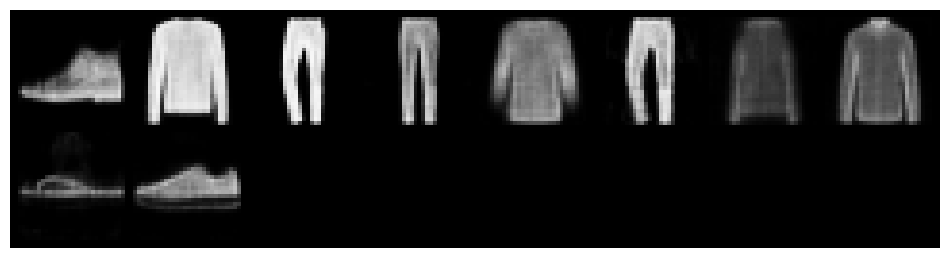

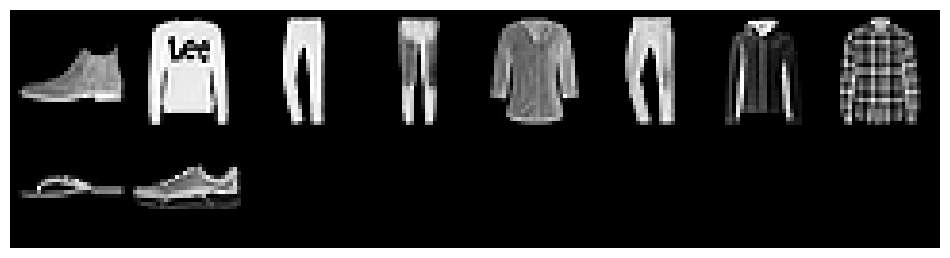


Test set: Average loss: 48.9220

Train Epoch: 92 [0/60000 (0%)]	Loss: 0.052965
Train Epoch: 92 [12800/60000 (21%)]	Loss: 0.056936
Train Epoch: 92 [25600/60000 (43%)]	Loss: 0.056744
Train Epoch: 92 [38400/60000 (64%)]	Loss: 0.062421
Train Epoch: 92 [51200/60000 (85%)]	Loss: 0.059103

Test set: Average loss: 49.2424

Train Epoch: 93 [0/60000 (0%)]	Loss: 0.063565
Train Epoch: 93 [12800/60000 (21%)]	Loss: 0.058315
Train Epoch: 93 [25600/60000 (43%)]	Loss: 0.059779
Train Epoch: 93 [38400/60000 (64%)]	Loss: 0.065948
Train Epoch: 93 [51200/60000 (85%)]	Loss: 0.060569

Test set: Average loss: 49.0620

Train Epoch: 94 [0/60000 (0%)]	Loss: 0.067144
Train Epoch: 94 [12800/60000 (21%)]	Loss: 0.062506
Train Epoch: 94 [25600/60000 (43%)]	Loss: 0.065886
Train Epoch: 94 [38400/60000 (64%)]	Loss: 0.057906
Train Epoch: 94 [51200/60000 (85%)]	Loss: 0.063203

Test set: Average loss: 48.8921

Train Epoch: 95 [0/60000 (0%)]	Loss: 0.060095
Train Epoch: 95 [12800/60000 (21%)]	Loss: 0.061738
Train Epoch: 95 [

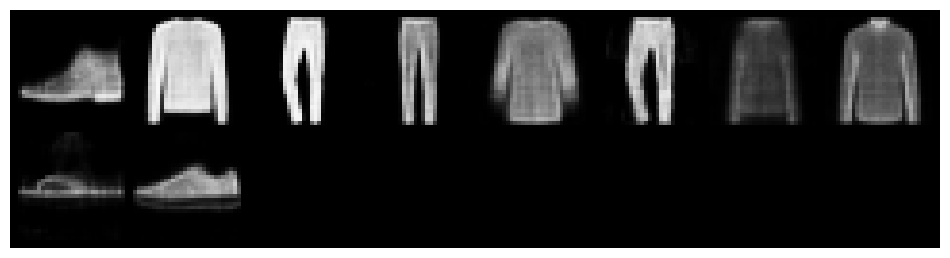

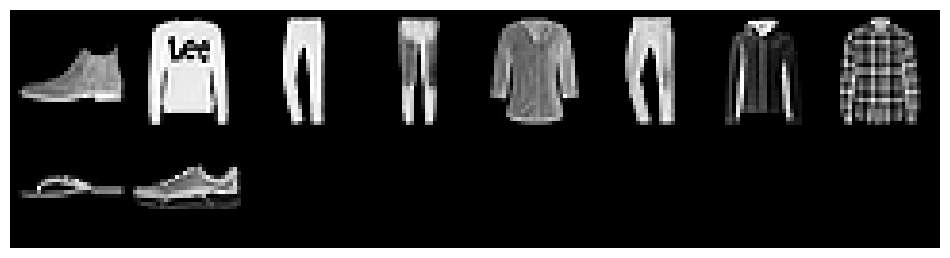


Test set: Average loss: 48.6959

The best(lowest) achieved loss: 48.696



In [18]:
best_loss = 1000. # something large
# run training
test(show_plot=True)
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test_loss = test(show_plot=epoch%10 == 1)
    if test_loss < best_loss:
        best_loss = test_loss
        if args.is_noisy:
            torch.save(model.state_dict(), 'best_fc_denoising_autoencoder.pth')
        else:
            torch.save(model.state_dict(), 'best_fc_autoencoder.pth')
# 
print('The best(lowest) achieved loss: {:.3f}\n'.format(best_loss))

# Task 2 Denoising Autoencoder

In [19]:
# create the model and move to GPU if available
model = Autoencoder()
if args.cuda:
    model.to(torch.device('cuda'))

# initialize the optimzation algorithm
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.momentum)

# use mean squared error loss as reconstruction loss
criterion = nn.MSELoss()

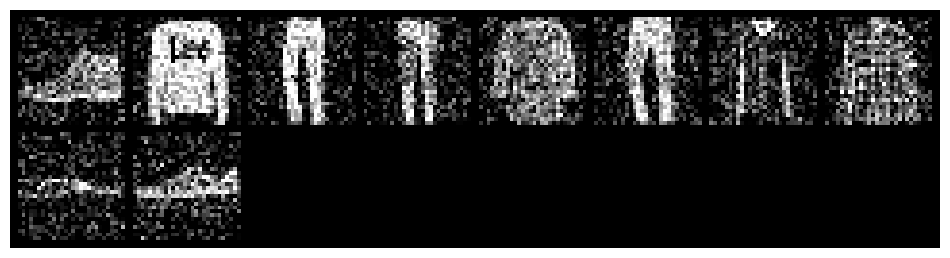

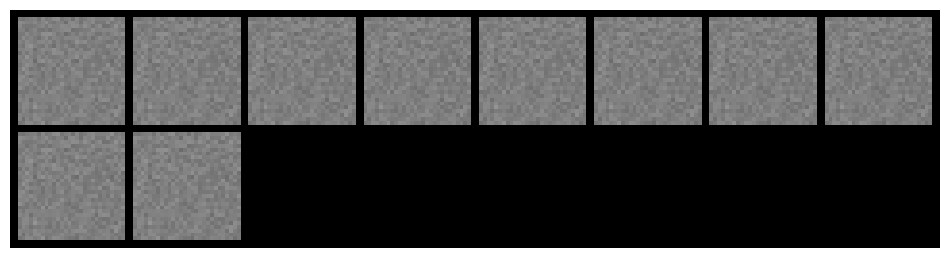

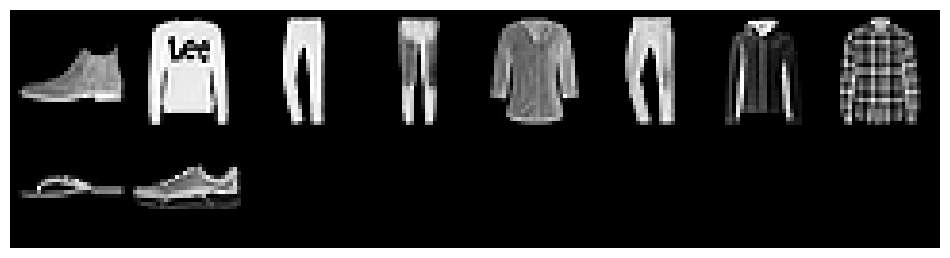


Test set: Average loss: 536.4156

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.704704
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.254578
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.156165
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.140893
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.132613


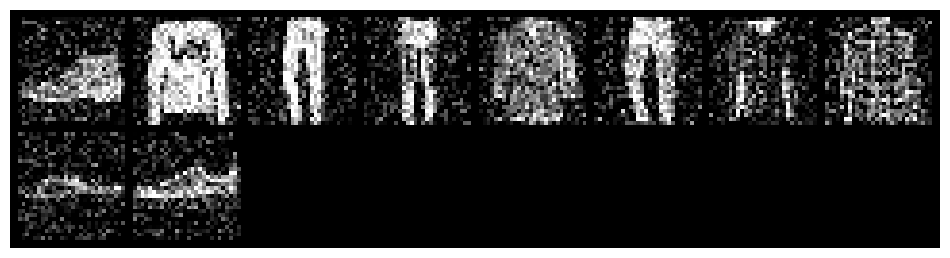

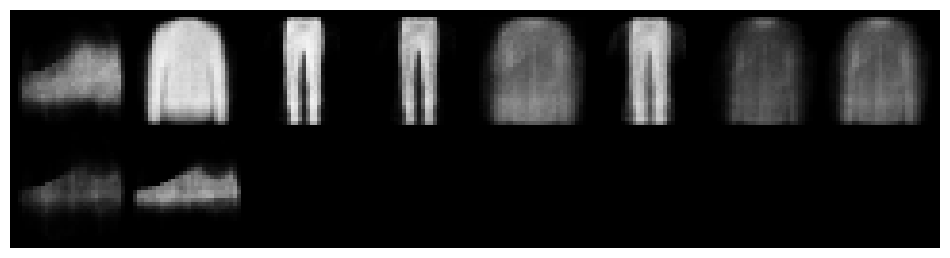

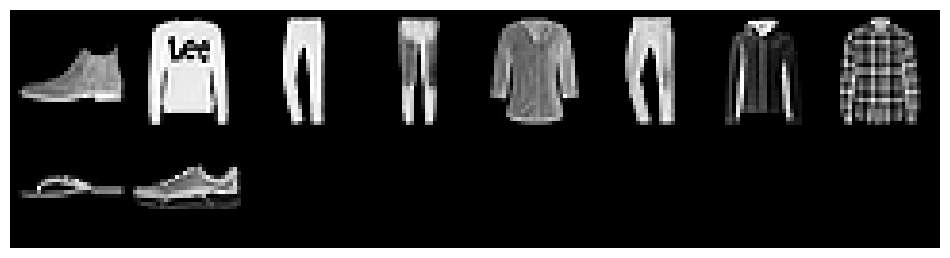


Test set: Average loss: 105.8940

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.134495
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.133833


Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.109427
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.114929
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.116417

Test set: Average loss: 89.3679

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.110706
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.114627
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.105064
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.106669
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.105580

Test set: Average loss: 79.7841

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.106524
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.096453
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.091491
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.090434
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.092319

Test set: Average loss: 75.8181

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.095859
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.089416
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.091315
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.094479
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.100674

Test set: Av

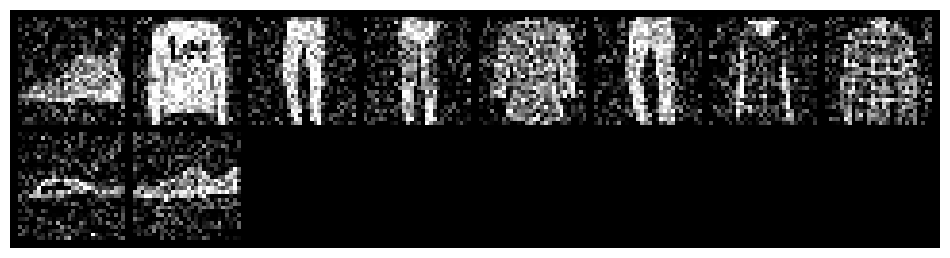

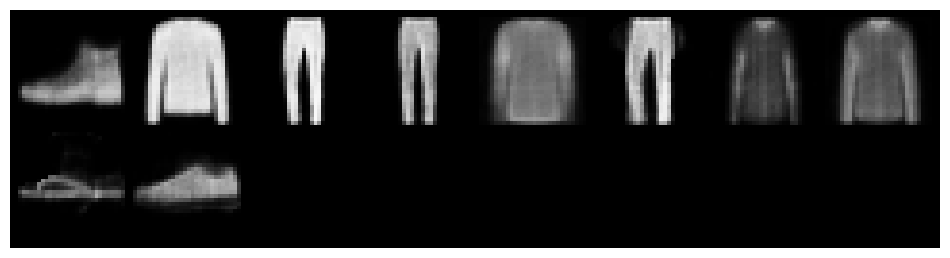

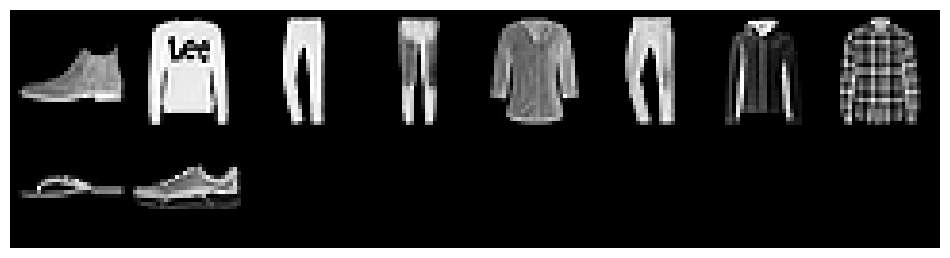


Test set: Average loss: 66.7596

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.087545
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.080939
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.079501
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.082439
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.086909

Test set: Average loss: 66.3494

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.083859
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.092011
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.074402
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.084444
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.081586

Test set: Average loss: 66.3811

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.085612
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.081004
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.088943
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.083334
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.083835

Test set: Average loss: 65.7022

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.087738
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.078638
Train Epoch: 15 [

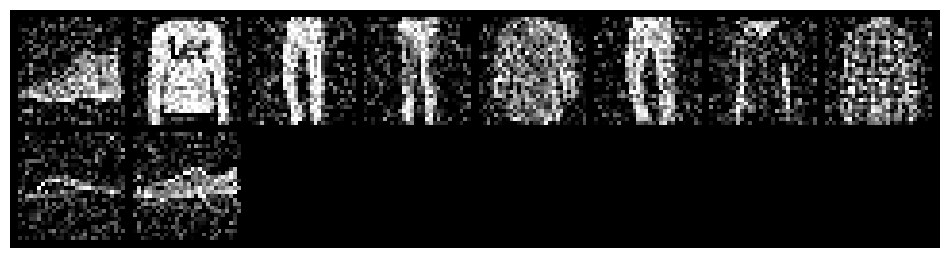

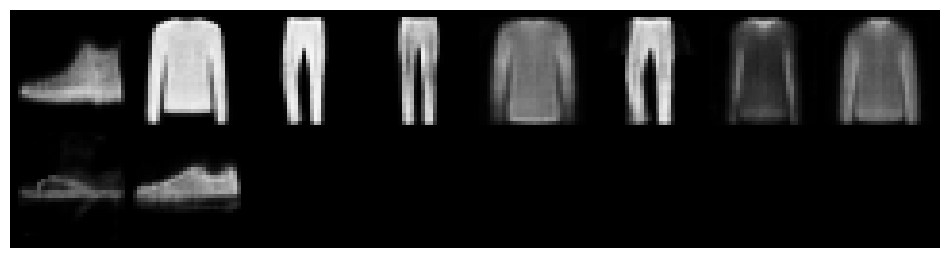

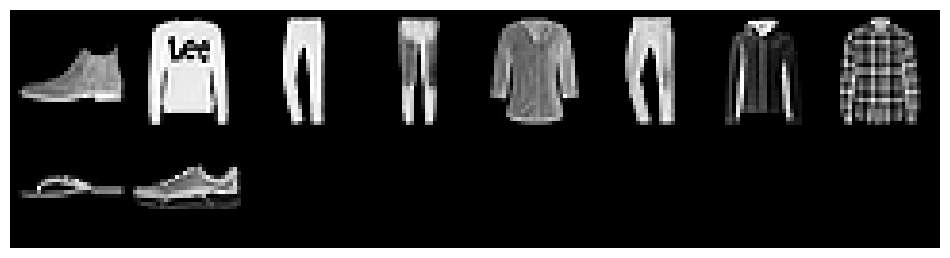


Test set: Average loss: 61.1422

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.069905
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.076462
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.077738
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.081511
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.084654

Test set: Average loss: 60.8965

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.072246
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.086312
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.078333
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.072221
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.079356

Test set: Average loss: 60.3578

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.068745
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.073212
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.076734
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.071038
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.073240

Test set: Average loss: 60.3093

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.076382
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.078612
Train Epoch: 25 [

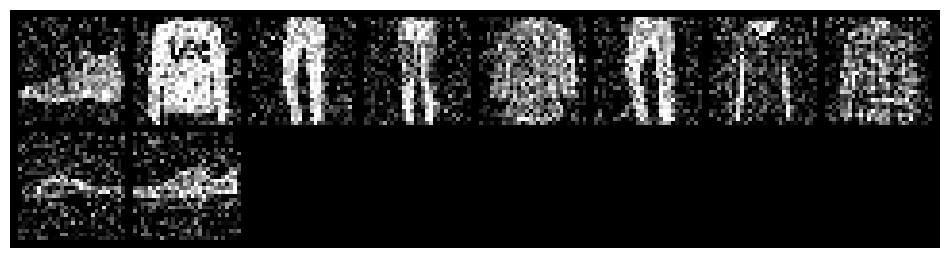

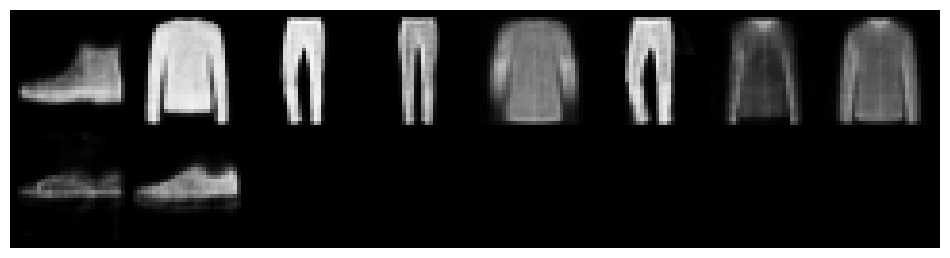

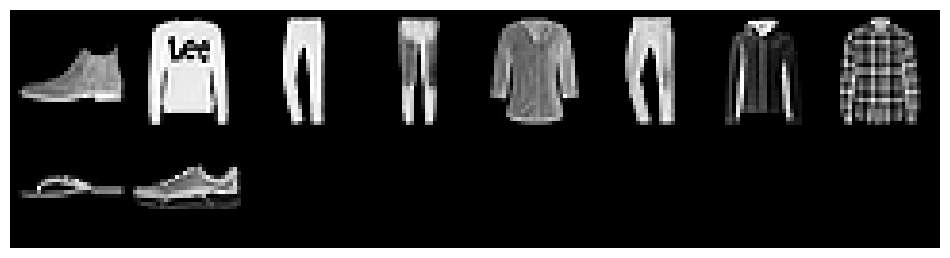


Test set: Average loss: 58.8949

Train Epoch: 32 [0/60000 (0%)]	Loss: 0.070949
Train Epoch: 32 [12800/60000 (21%)]	Loss: 0.070546
Train Epoch: 32 [25600/60000 (43%)]	Loss: 0.070771
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.072171
Train Epoch: 32 [51200/60000 (85%)]	Loss: 0.075663

Test set: Average loss: 58.6374

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.070290
Train Epoch: 33 [12800/60000 (21%)]	Loss: 0.074165
Train Epoch: 33 [25600/60000 (43%)]	Loss: 0.079170
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.068932
Train Epoch: 33 [51200/60000 (85%)]	Loss: 0.070041

Test set: Average loss: 58.8488

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.072282
Train Epoch: 34 [12800/60000 (21%)]	Loss: 0.079458
Train Epoch: 34 [25600/60000 (43%)]	Loss: 0.069747
Train Epoch: 34 [38400/60000 (64%)]	Loss: 0.069550
Train Epoch: 34 [51200/60000 (85%)]	Loss: 0.075601

Test set: Average loss: 58.5307

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.070744
Train Epoch: 35 [12800/60000 (21%)]	Loss: 0.069364
Train Epoch: 35 [

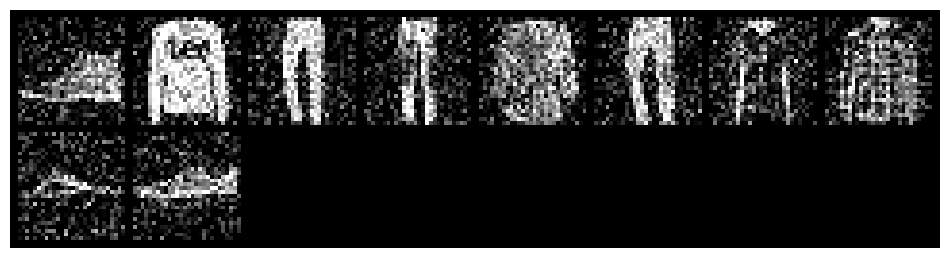

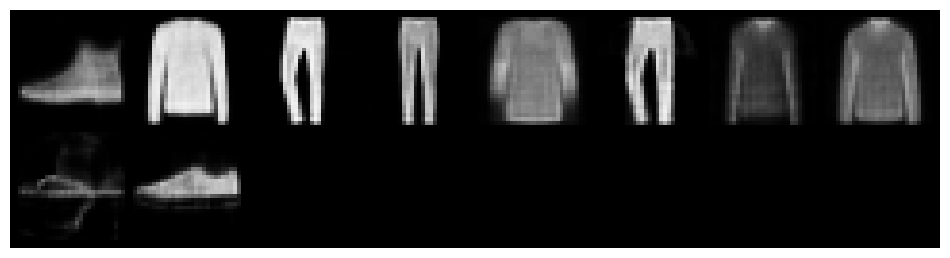

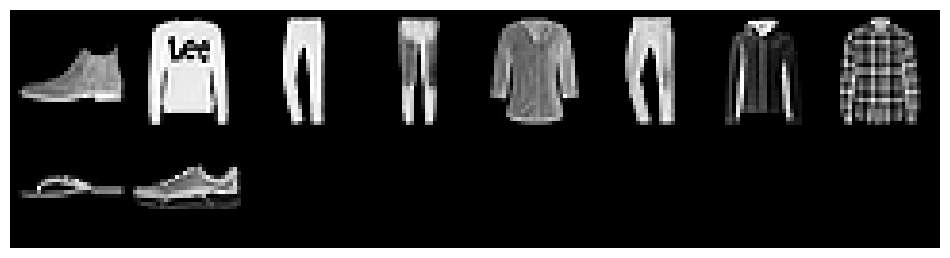


Test set: Average loss: 57.3807

Train Epoch: 42 [0/60000 (0%)]	Loss: 0.065778
Train Epoch: 42 [12800/60000 (21%)]	Loss: 0.072235
Train Epoch: 42 [25600/60000 (43%)]	Loss: 0.072529
Train Epoch: 42 [38400/60000 (64%)]	Loss: 0.070110
Train Epoch: 42 [51200/60000 (85%)]	Loss: 0.079499

Test set: Average loss: 57.0296

Train Epoch: 43 [0/60000 (0%)]	Loss: 0.075637
Train Epoch: 43 [12800/60000 (21%)]	Loss: 0.071671
Train Epoch: 43 [25600/60000 (43%)]	Loss: 0.069715
Train Epoch: 43 [38400/60000 (64%)]	Loss: 0.069080
Train Epoch: 43 [51200/60000 (85%)]	Loss: 0.073254

Test set: Average loss: 56.8685

Train Epoch: 44 [0/60000 (0%)]	Loss: 0.066554
Train Epoch: 44 [12800/60000 (21%)]	Loss: 0.077744
Train Epoch: 44 [25600/60000 (43%)]	Loss: 0.067214
Train Epoch: 44 [38400/60000 (64%)]	Loss: 0.068296
Train Epoch: 44 [51200/60000 (85%)]	Loss: 0.071505

Test set: Average loss: 57.1780

Train Epoch: 45 [0/60000 (0%)]	Loss: 0.069237
Train Epoch: 45 [12800/60000 (21%)]	Loss: 0.072754
Train Epoch: 45 [

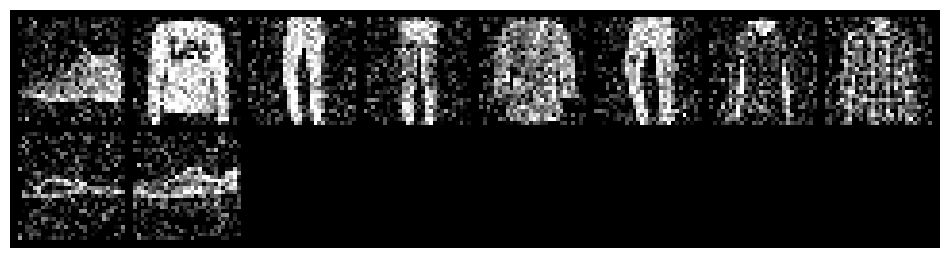

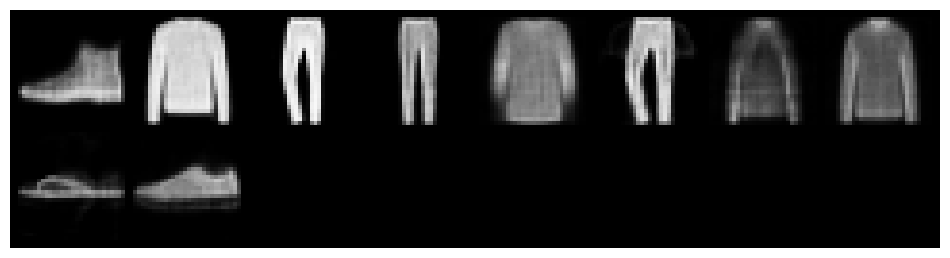

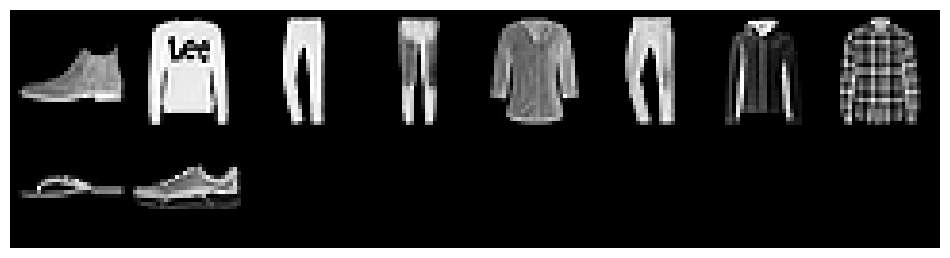


Test set: Average loss: 56.3075

Train Epoch: 52 [0/60000 (0%)]	Loss: 0.074468
Train Epoch: 52 [12800/60000 (21%)]	Loss: 0.065048
Train Epoch: 52 [25600/60000 (43%)]	Loss: 0.079183
Train Epoch: 52 [38400/60000 (64%)]	Loss: 0.065579
Train Epoch: 52 [51200/60000 (85%)]	Loss: 0.069853

Test set: Average loss: 56.1434

Train Epoch: 53 [0/60000 (0%)]	Loss: 0.062848
Train Epoch: 53 [12800/60000 (21%)]	Loss: 0.068645
Train Epoch: 53 [25600/60000 (43%)]	Loss: 0.070118
Train Epoch: 53 [38400/60000 (64%)]	Loss: 0.073796
Train Epoch: 53 [51200/60000 (85%)]	Loss: 0.071870

Test set: Average loss: 56.4885

Train Epoch: 54 [0/60000 (0%)]	Loss: 0.066145
Train Epoch: 54 [12800/60000 (21%)]	Loss: 0.072397
Train Epoch: 54 [25600/60000 (43%)]	Loss: 0.067210
Train Epoch: 54 [38400/60000 (64%)]	Loss: 0.079348
Train Epoch: 54 [51200/60000 (85%)]	Loss: 0.062914

Test set: Average loss: 56.2269

Train Epoch: 55 [0/60000 (0%)]	Loss: 0.067107
Train Epoch: 55 [12800/60000 (21%)]	Loss: 0.065850
Train Epoch: 55 [

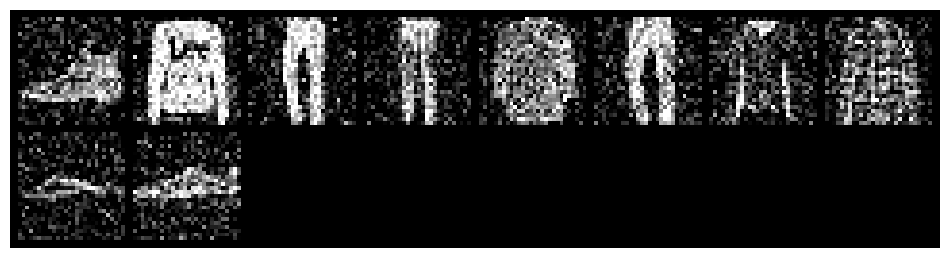

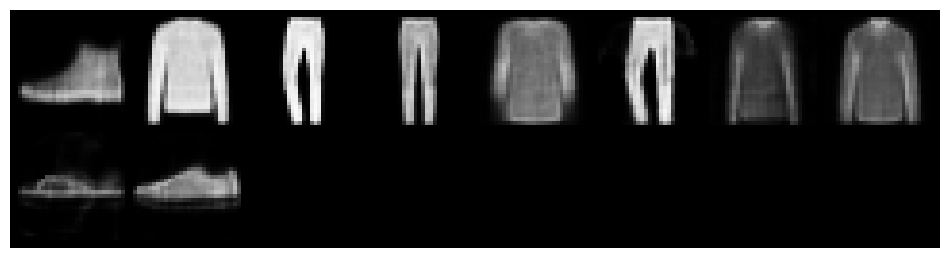

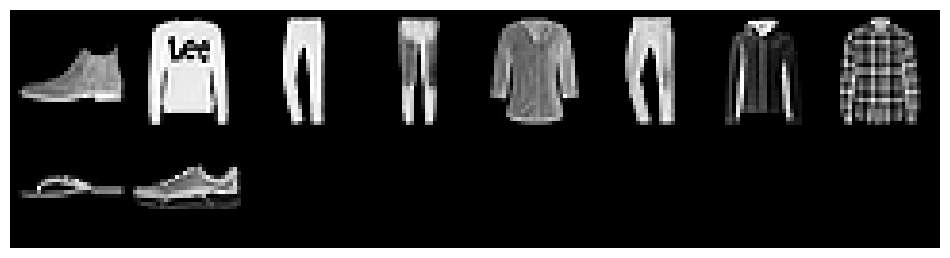


Test set: Average loss: 55.6717

Train Epoch: 62 [0/60000 (0%)]	Loss: 0.073700
Train Epoch: 62 [12800/60000 (21%)]	Loss: 0.074043
Train Epoch: 62 [25600/60000 (43%)]	Loss: 0.070243
Train Epoch: 62 [38400/60000 (64%)]	Loss: 0.066935
Train Epoch: 62 [51200/60000 (85%)]	Loss: 0.067340

Test set: Average loss: 54.7808

Train Epoch: 63 [0/60000 (0%)]	Loss: 0.065666
Train Epoch: 63 [12800/60000 (21%)]	Loss: 0.070643
Train Epoch: 63 [25600/60000 (43%)]	Loss: 0.069858
Train Epoch: 63 [38400/60000 (64%)]	Loss: 0.070200
Train Epoch: 63 [51200/60000 (85%)]	Loss: 0.066299

Test set: Average loss: 54.3914

Train Epoch: 64 [0/60000 (0%)]	Loss: 0.066837
Train Epoch: 64 [12800/60000 (21%)]	Loss: 0.072168
Train Epoch: 64 [25600/60000 (43%)]	Loss: 0.068518
Train Epoch: 64 [38400/60000 (64%)]	Loss: 0.068707
Train Epoch: 64 [51200/60000 (85%)]	Loss: 0.064067

Test set: Average loss: 54.1848

Train Epoch: 65 [0/60000 (0%)]	Loss: 0.068059
Train Epoch: 65 [12800/60000 (21%)]	Loss: 0.066716
Train Epoch: 65 [

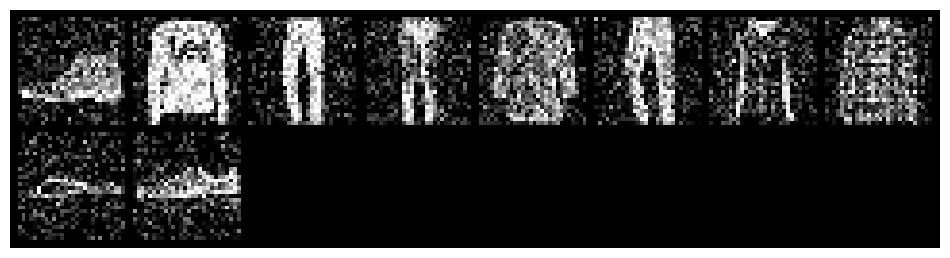

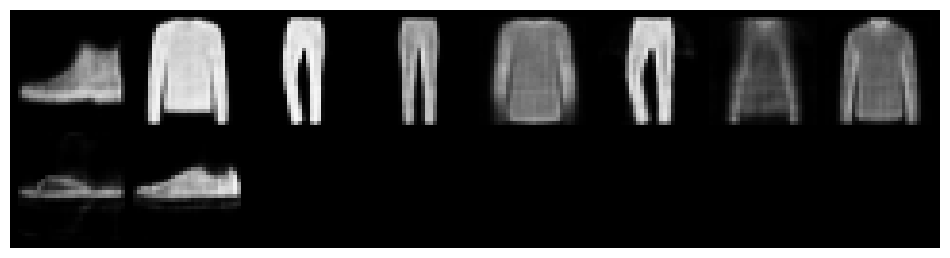

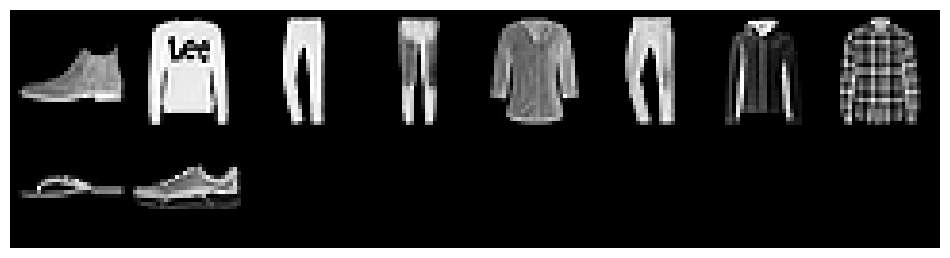


Test set: Average loss: 53.7233

Train Epoch: 72 [0/60000 (0%)]	Loss: 0.070870
Train Epoch: 72 [12800/60000 (21%)]	Loss: 0.063226
Train Epoch: 72 [25600/60000 (43%)]	Loss: 0.071341
Train Epoch: 72 [38400/60000 (64%)]	Loss: 0.069081
Train Epoch: 72 [51200/60000 (85%)]	Loss: 0.065399

Test set: Average loss: 52.8813

Train Epoch: 73 [0/60000 (0%)]	Loss: 0.066255
Train Epoch: 73 [12800/60000 (21%)]	Loss: 0.070942
Train Epoch: 73 [25600/60000 (43%)]	Loss: 0.072236
Train Epoch: 73 [38400/60000 (64%)]	Loss: 0.067479
Train Epoch: 73 [51200/60000 (85%)]	Loss: 0.065408

Test set: Average loss: 53.0034

Train Epoch: 74 [0/60000 (0%)]	Loss: 0.068437
Train Epoch: 74 [12800/60000 (21%)]	Loss: 0.060408
Train Epoch: 74 [25600/60000 (43%)]	Loss: 0.063443
Train Epoch: 74 [38400/60000 (64%)]	Loss: 0.073342
Train Epoch: 74 [51200/60000 (85%)]	Loss: 0.067354

Test set: Average loss: 52.6330

Train Epoch: 75 [0/60000 (0%)]	Loss: 0.067342
Train Epoch: 75 [12800/60000 (21%)]	Loss: 0.065267
Train Epoch: 75 [

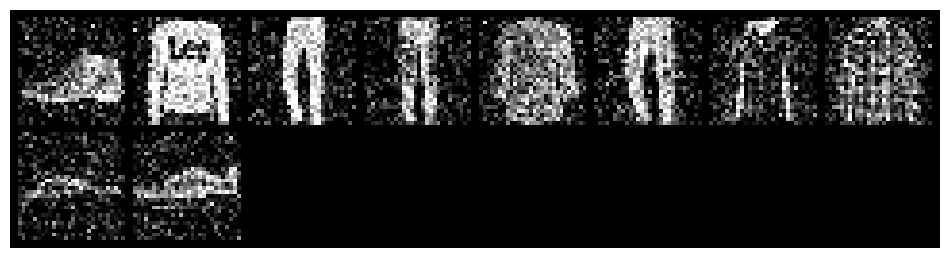

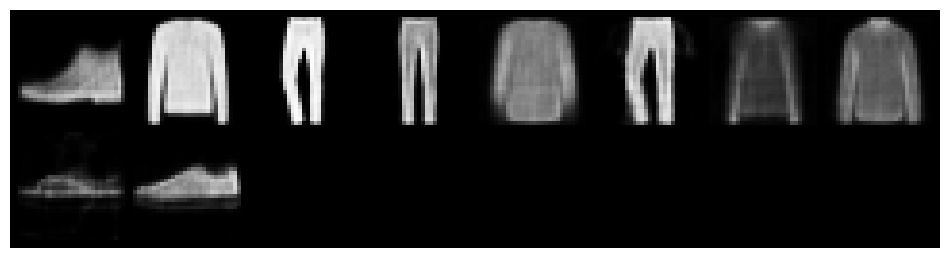

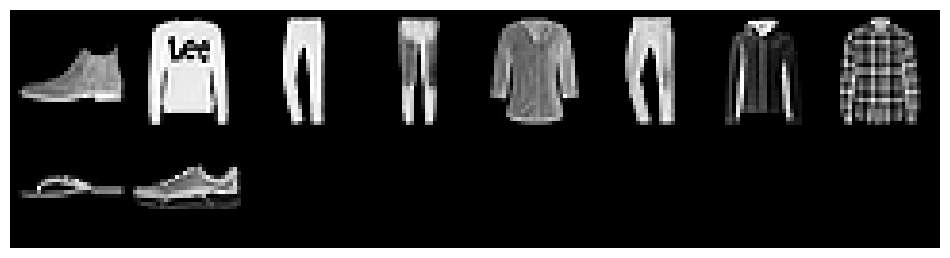


Test set: Average loss: 52.1869

Train Epoch: 82 [0/60000 (0%)]	Loss: 0.064603
Train Epoch: 82 [12800/60000 (21%)]	Loss: 0.072561
Train Epoch: 82 [25600/60000 (43%)]	Loss: 0.067023
Train Epoch: 82 [38400/60000 (64%)]	Loss: 0.059093
Train Epoch: 82 [51200/60000 (85%)]	Loss: 0.069549

Test set: Average loss: 52.4869

Train Epoch: 83 [0/60000 (0%)]	Loss: 0.061455
Train Epoch: 83 [12800/60000 (21%)]	Loss: 0.069389
Train Epoch: 83 [25600/60000 (43%)]	Loss: 0.057323
Train Epoch: 83 [38400/60000 (64%)]	Loss: 0.064335
Train Epoch: 83 [51200/60000 (85%)]	Loss: 0.067632

Test set: Average loss: 52.7666

Train Epoch: 84 [0/60000 (0%)]	Loss: 0.065140
Train Epoch: 84 [12800/60000 (21%)]	Loss: 0.065999
Train Epoch: 84 [25600/60000 (43%)]	Loss: 0.066606
Train Epoch: 84 [38400/60000 (64%)]	Loss: 0.063966
Train Epoch: 84 [51200/60000 (85%)]	Loss: 0.068615

Test set: Average loss: 52.1459

Train Epoch: 85 [0/60000 (0%)]	Loss: 0.065273
Train Epoch: 85 [12800/60000 (21%)]	Loss: 0.071275
Train Epoch: 85 [

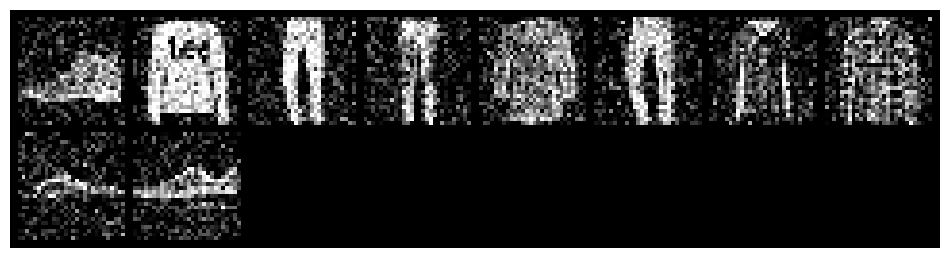

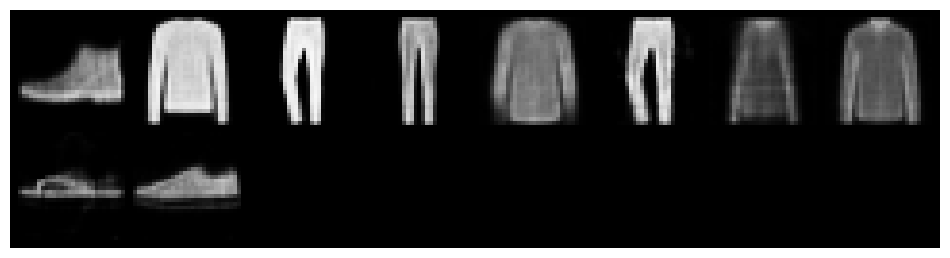

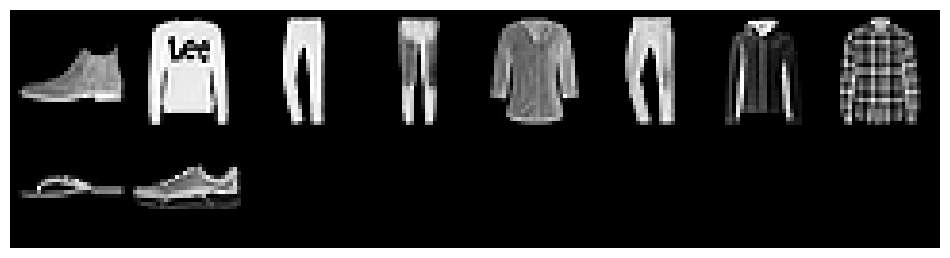


Test set: Average loss: 51.9744

Train Epoch: 92 [0/60000 (0%)]	Loss: 0.057821
Train Epoch: 92 [12800/60000 (21%)]	Loss: 0.066880
Train Epoch: 92 [25600/60000 (43%)]	Loss: 0.065060
Train Epoch: 92 [38400/60000 (64%)]	Loss: 0.069694
Train Epoch: 92 [51200/60000 (85%)]	Loss: 0.060959

Test set: Average loss: 53.1364

Train Epoch: 93 [0/60000 (0%)]	Loss: 0.063962
Train Epoch: 93 [12800/60000 (21%)]	Loss: 0.059655
Train Epoch: 93 [25600/60000 (43%)]	Loss: 0.059418
Train Epoch: 93 [38400/60000 (64%)]	Loss: 0.058938
Train Epoch: 93 [51200/60000 (85%)]	Loss: 0.068503

Test set: Average loss: 51.9523

Train Epoch: 94 [0/60000 (0%)]	Loss: 0.068550
Train Epoch: 94 [12800/60000 (21%)]	Loss: 0.062861
Train Epoch: 94 [25600/60000 (43%)]	Loss: 0.063229
Train Epoch: 94 [38400/60000 (64%)]	Loss: 0.060553
Train Epoch: 94 [51200/60000 (85%)]	Loss: 0.067508

Test set: Average loss: 51.7720

Train Epoch: 95 [0/60000 (0%)]	Loss: 0.069526
Train Epoch: 95 [12800/60000 (21%)]	Loss: 0.061854
Train Epoch: 95 [

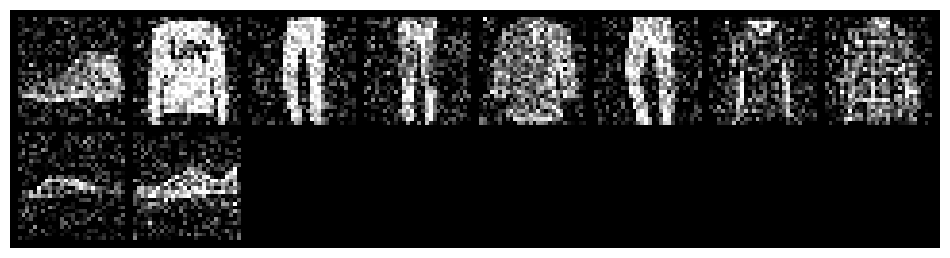

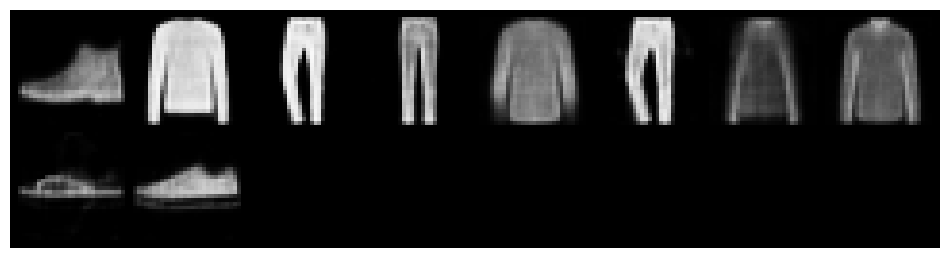

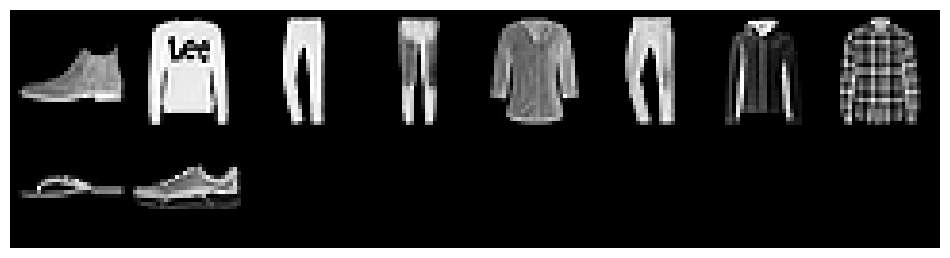


Test set: Average loss: 51.9813

The best(lowest) achieved loss: 51.552



In [20]:
best_loss = 1000. # something large
# run training
args.is_noisy = True
test(show_plot=True)
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test_loss = test(show_plot=epoch%10 == 1)
    if test_loss < best_loss:
        best_loss = test_loss
        if args.is_noisy:
            torch.save(model.state_dict(), 'best_fc_denoising_autoencoder.pth')
        else:
            torch.save(model.state_dict(), 'best_fc_autoencoder.pth')
# 
print('The best(lowest) achieved loss: {:.3f}\n'.format(best_loss))

# Task 3 Convolutional AE

In [132]:
class AE_Autoencoder(nn.Module):
    def __init__(self):
        super(AE_Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 10),
            # 10
            nn.Softmax(),
            )
        
        self.decoder = nn.Sequential(
            # 10
            nn.Linear(10, 400),
            # 400
            nn.ReLU(),
            nn.Linear(400, 4000),
            # 4000
            nn.ReLU(),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ReLU(),
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Tanh(),
            )
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 28*28)
        return x

In [133]:
# create the model and move to GPU if available
model = AE_Autoencoder()
if args.cuda:
    model.to(torch.device('cuda'))

# initialize the optimzation algorithm
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.momentum)

# use mean squared error loss as reconstruction loss
criterion = nn.MSELoss()

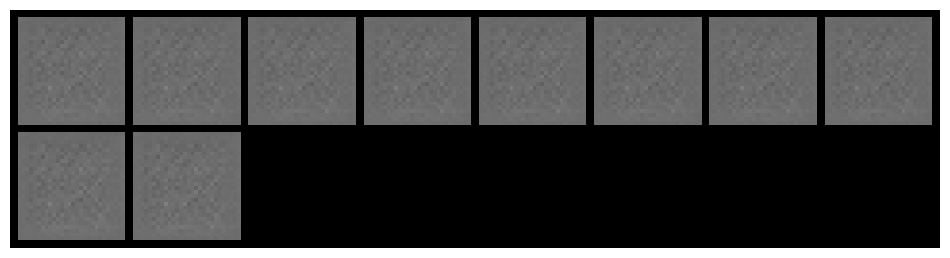

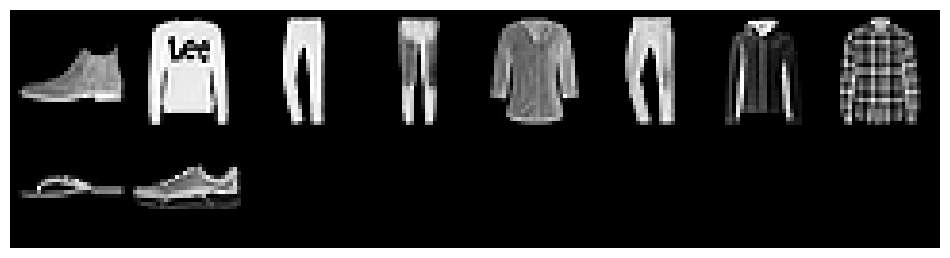


Test set: Average loss: 451.2271

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.572953
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.167437
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.118618
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.112039
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.094838


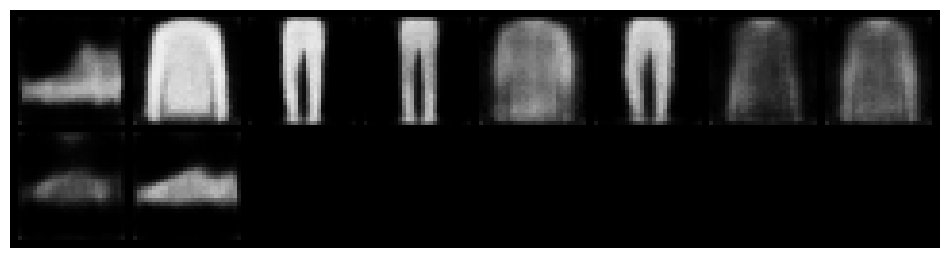

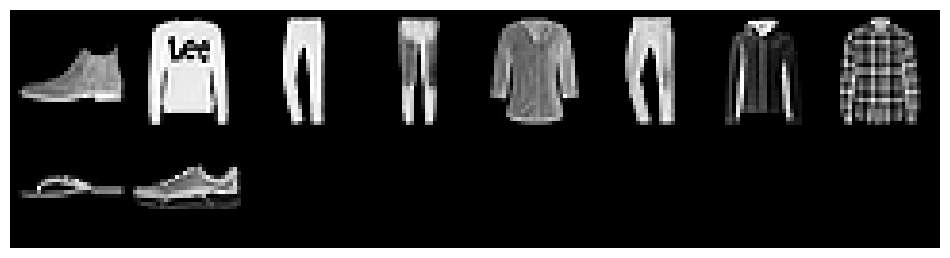


Test set: Average loss: 74.8310

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.098770
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.089182
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.095457
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.084536
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.081659

Test set: Average loss: 64.7614

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.082144
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.081383
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.079761
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.080544
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.081364

Test set: Average loss: 59.7990

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.072838
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.077212
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.071556
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.079354
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.071359

Test set: Average loss: 57.5175

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.069927
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.064247
Train Epoch: 5 [25600/60000 (43%)]

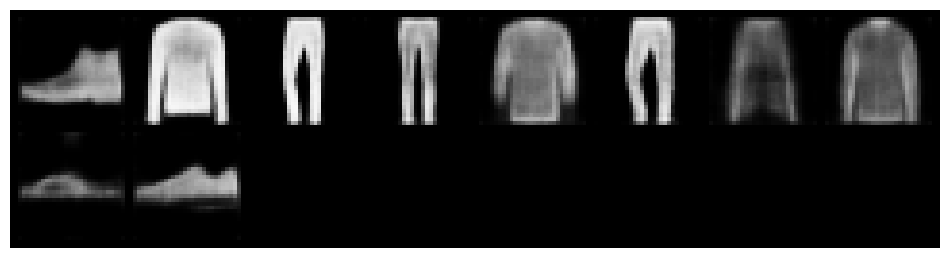

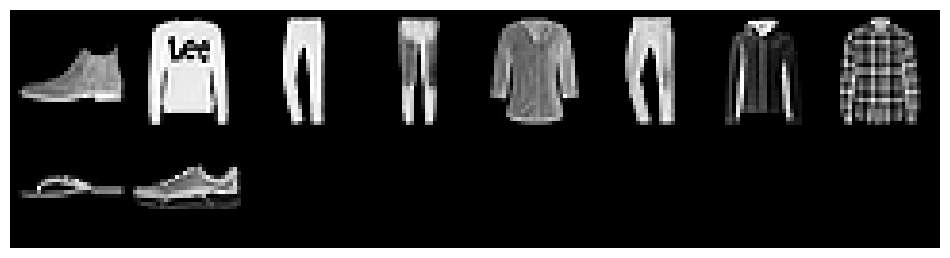


Test set: Average loss: 48.1345

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.060386
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.061150
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.059470
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.054747
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.058386

Test set: Average loss: 47.4872

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.061180
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.061253
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.055898
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.056054
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.062710

Test set: Average loss: 46.8884

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.064847
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.054264
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.052492
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.066563
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.053308

Test set: Average loss: 46.2349

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.057004
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.053220
Train Epoch: 15 [

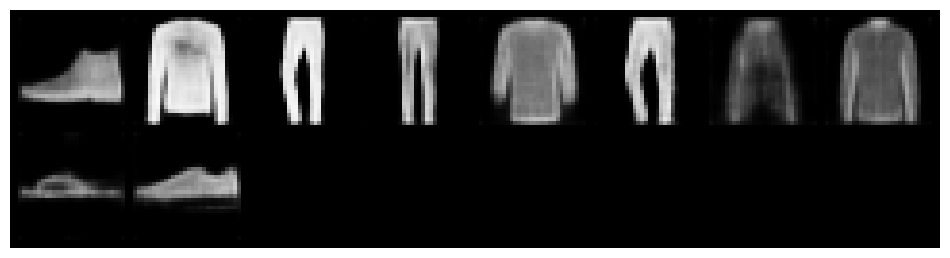

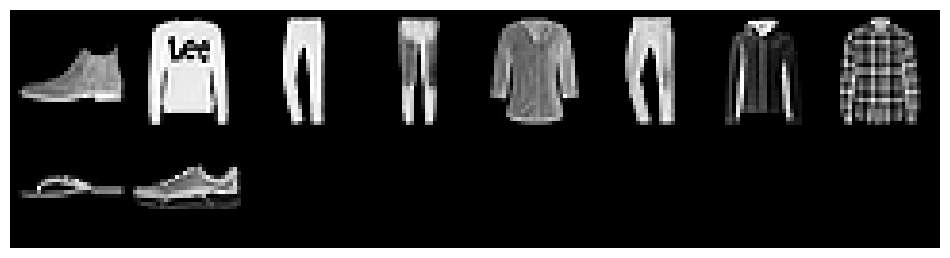


Test set: Average loss: 43.7984

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.055851
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.048423
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.053909
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.056093
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.056068

Test set: Average loss: 43.4579

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.052524
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.053083
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.056265
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.054331
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.052665

Test set: Average loss: 42.9177

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.048459
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.048385
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.056637
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.048491
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.059062

Test set: Average loss: 42.9168

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.061942
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.048396
Train Epoch: 25 [

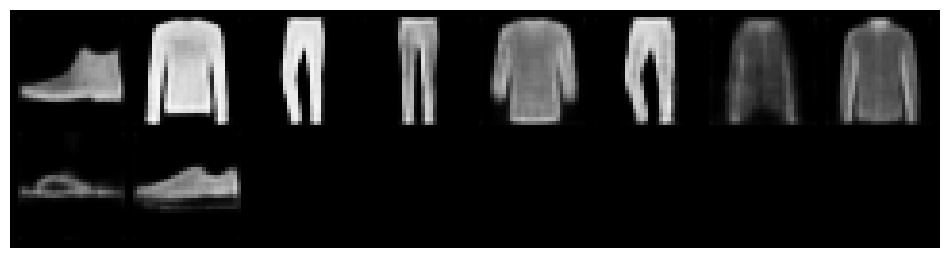

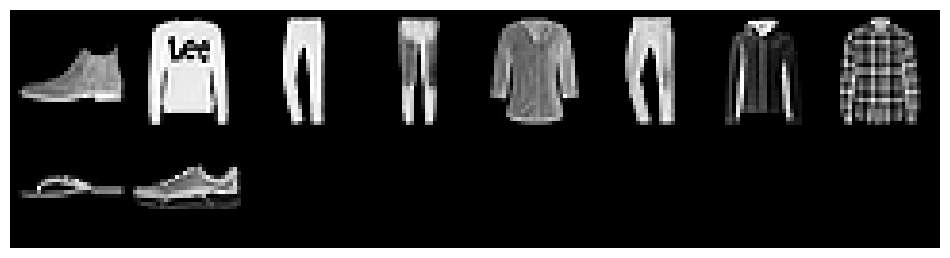


Test set: Average loss: 41.6106

Train Epoch: 32 [0/60000 (0%)]	Loss: 0.049088
Train Epoch: 32 [12800/60000 (21%)]	Loss: 0.053282
Train Epoch: 32 [25600/60000 (43%)]	Loss: 0.050671
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.052133
Train Epoch: 32 [51200/60000 (85%)]	Loss: 0.054909

Test set: Average loss: 41.0530

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.048894
Train Epoch: 33 [12800/60000 (21%)]	Loss: 0.057787
Train Epoch: 33 [25600/60000 (43%)]	Loss: 0.056564
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.049503
Train Epoch: 33 [51200/60000 (85%)]	Loss: 0.051788

Test set: Average loss: 41.4135

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.051254
Train Epoch: 34 [12800/60000 (21%)]	Loss: 0.052473
Train Epoch: 34 [25600/60000 (43%)]	Loss: 0.053655
Train Epoch: 34 [38400/60000 (64%)]	Loss: 0.054696
Train Epoch: 34 [51200/60000 (85%)]	Loss: 0.048073

Test set: Average loss: 41.5435

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.050822
Train Epoch: 35 [12800/60000 (21%)]	Loss: 0.050592
Train Epoch: 35 [

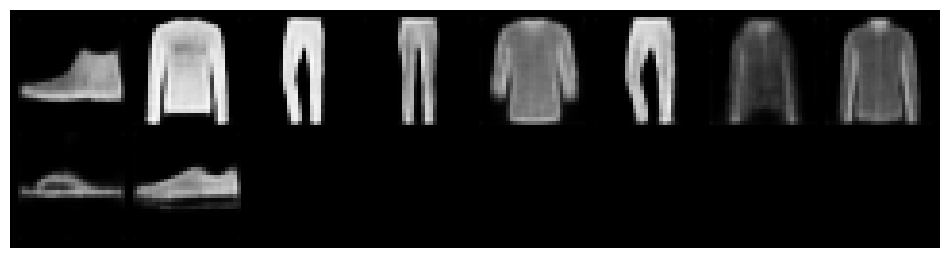

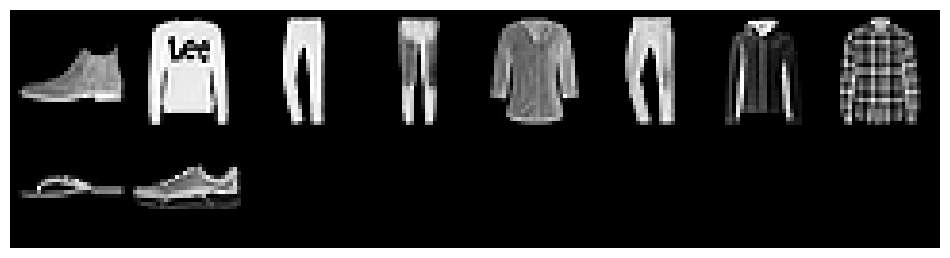


Test set: Average loss: 40.6555

Train Epoch: 42 [0/60000 (0%)]	Loss: 0.050749
Train Epoch: 42 [12800/60000 (21%)]	Loss: 0.049514
Train Epoch: 42 [25600/60000 (43%)]	Loss: 0.054886
Train Epoch: 42 [38400/60000 (64%)]	Loss: 0.048312
Train Epoch: 42 [51200/60000 (85%)]	Loss: 0.052935

Test set: Average loss: 40.6032

Train Epoch: 43 [0/60000 (0%)]	Loss: 0.051930
Train Epoch: 43 [12800/60000 (21%)]	Loss: 0.059815
Train Epoch: 43 [25600/60000 (43%)]	Loss: 0.046723
Train Epoch: 43 [38400/60000 (64%)]	Loss: 0.051690
Train Epoch: 43 [51200/60000 (85%)]	Loss: 0.051719

Test set: Average loss: 40.6436

Train Epoch: 44 [0/60000 (0%)]	Loss: 0.044360
Train Epoch: 44 [12800/60000 (21%)]	Loss: 0.052418
Train Epoch: 44 [25600/60000 (43%)]	Loss: 0.048777
Train Epoch: 44 [38400/60000 (64%)]	Loss: 0.046969
Train Epoch: 44 [51200/60000 (85%)]	Loss: 0.053543

Test set: Average loss: 41.0728

Train Epoch: 45 [0/60000 (0%)]	Loss: 0.044811
Train Epoch: 45 [12800/60000 (21%)]	Loss: 0.049593
Train Epoch: 45 [

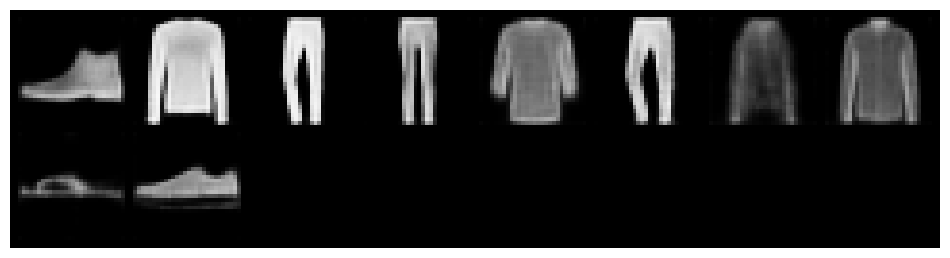

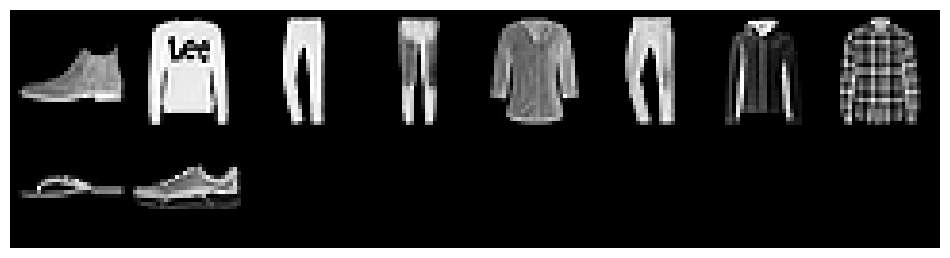


Test set: Average loss: 40.9911

Train Epoch: 52 [0/60000 (0%)]	Loss: 0.050937
Train Epoch: 52 [12800/60000 (21%)]	Loss: 0.047256
Train Epoch: 52 [25600/60000 (43%)]	Loss: 0.048310
Train Epoch: 52 [38400/60000 (64%)]	Loss: 0.047322
Train Epoch: 52 [51200/60000 (85%)]	Loss: 0.052093

Test set: Average loss: 40.2564

Train Epoch: 53 [0/60000 (0%)]	Loss: 0.052367
Train Epoch: 53 [12800/60000 (21%)]	Loss: 0.056081
Train Epoch: 53 [25600/60000 (43%)]	Loss: 0.044401
Train Epoch: 53 [38400/60000 (64%)]	Loss: 0.046325
Train Epoch: 53 [51200/60000 (85%)]	Loss: 0.048896

Test set: Average loss: 40.0479

Train Epoch: 54 [0/60000 (0%)]	Loss: 0.052290
Train Epoch: 54 [12800/60000 (21%)]	Loss: 0.050897
Train Epoch: 54 [25600/60000 (43%)]	Loss: 0.048907
Train Epoch: 54 [38400/60000 (64%)]	Loss: 0.050280
Train Epoch: 54 [51200/60000 (85%)]	Loss: 0.053060

Test set: Average loss: 39.9167

Train Epoch: 55 [0/60000 (0%)]	Loss: 0.048081
Train Epoch: 55 [12800/60000 (21%)]	Loss: 0.049664
Train Epoch: 55 [

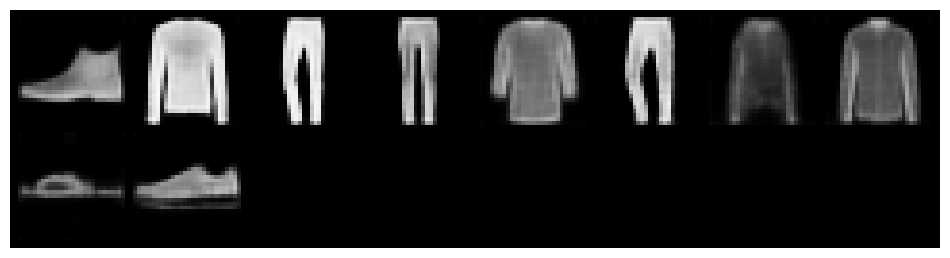

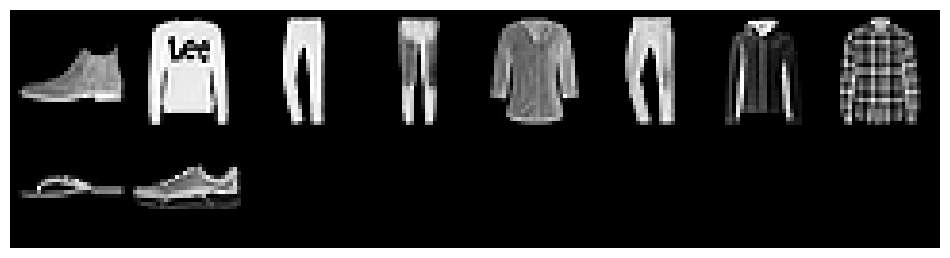


Test set: Average loss: 39.7032

Train Epoch: 62 [0/60000 (0%)]	Loss: 0.047703
Train Epoch: 62 [12800/60000 (21%)]	Loss: 0.048370
Train Epoch: 62 [25600/60000 (43%)]	Loss: 0.051954
Train Epoch: 62 [38400/60000 (64%)]	Loss: 0.050405
Train Epoch: 62 [51200/60000 (85%)]	Loss: 0.053261

Test set: Average loss: 40.1239

Train Epoch: 63 [0/60000 (0%)]	Loss: 0.052776
Train Epoch: 63 [12800/60000 (21%)]	Loss: 0.047972
Train Epoch: 63 [25600/60000 (43%)]	Loss: 0.054738
Train Epoch: 63 [38400/60000 (64%)]	Loss: 0.050337
Train Epoch: 63 [51200/60000 (85%)]	Loss: 0.046524

Test set: Average loss: 39.5738

Train Epoch: 64 [0/60000 (0%)]	Loss: 0.050988
Train Epoch: 64 [12800/60000 (21%)]	Loss: 0.047066
Train Epoch: 64 [25600/60000 (43%)]	Loss: 0.051051
Train Epoch: 64 [38400/60000 (64%)]	Loss: 0.047472
Train Epoch: 64 [51200/60000 (85%)]	Loss: 0.047226

Test set: Average loss: 39.6015

Train Epoch: 65 [0/60000 (0%)]	Loss: 0.051898
Train Epoch: 65 [12800/60000 (21%)]	Loss: 0.050194
Train Epoch: 65 [

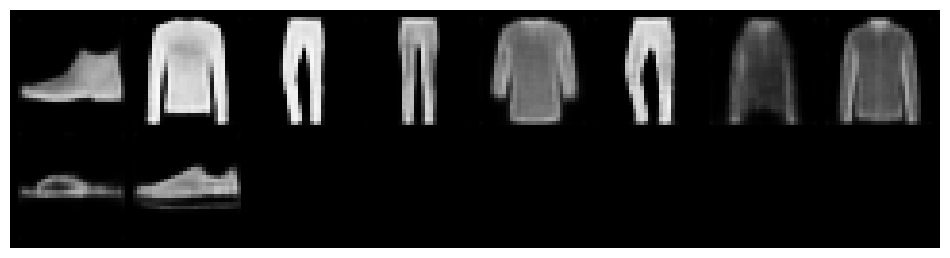

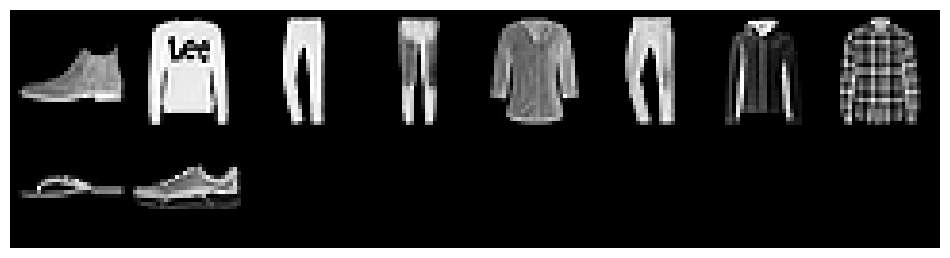


Test set: Average loss: 39.7884

Train Epoch: 72 [0/60000 (0%)]	Loss: 0.050068
Train Epoch: 72 [12800/60000 (21%)]	Loss: 0.052293
Train Epoch: 72 [25600/60000 (43%)]	Loss: 0.054973
Train Epoch: 72 [38400/60000 (64%)]	Loss: 0.049128
Train Epoch: 72 [51200/60000 (85%)]	Loss: 0.047893

Test set: Average loss: 39.4052

Train Epoch: 73 [0/60000 (0%)]	Loss: 0.053411
Train Epoch: 73 [12800/60000 (21%)]	Loss: 0.043932
Train Epoch: 73 [25600/60000 (43%)]	Loss: 0.047124
Train Epoch: 73 [38400/60000 (64%)]	Loss: 0.051552
Train Epoch: 73 [51200/60000 (85%)]	Loss: 0.046265

Test set: Average loss: 39.4616

Train Epoch: 74 [0/60000 (0%)]	Loss: 0.047985
Train Epoch: 74 [12800/60000 (21%)]	Loss: 0.042025
Train Epoch: 74 [25600/60000 (43%)]	Loss: 0.046982
Train Epoch: 74 [38400/60000 (64%)]	Loss: 0.044099
Train Epoch: 74 [51200/60000 (85%)]	Loss: 0.049091

Test set: Average loss: 39.3996

Train Epoch: 75 [0/60000 (0%)]	Loss: 0.046296
Train Epoch: 75 [12800/60000 (21%)]	Loss: 0.047534
Train Epoch: 75 [

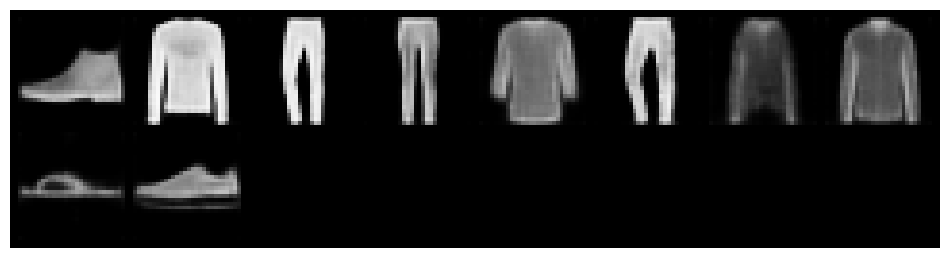

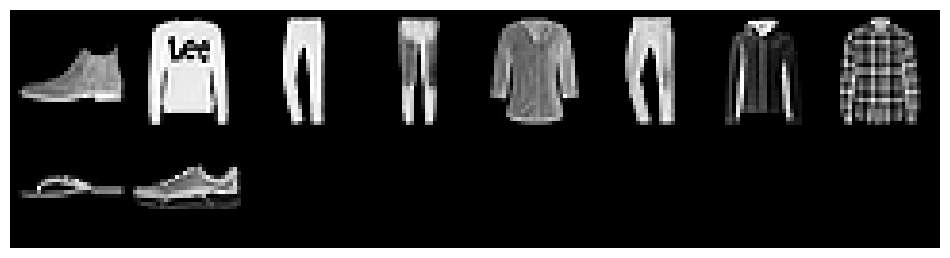


Test set: Average loss: 39.2768

Train Epoch: 82 [0/60000 (0%)]	Loss: 0.049045
Train Epoch: 82 [12800/60000 (21%)]	Loss: 0.048348
Train Epoch: 82 [25600/60000 (43%)]	Loss: 0.052240
Train Epoch: 82 [38400/60000 (64%)]	Loss: 0.045731
Train Epoch: 82 [51200/60000 (85%)]	Loss: 0.042855

Test set: Average loss: 39.4252

Train Epoch: 83 [0/60000 (0%)]	Loss: 0.046429
Train Epoch: 83 [12800/60000 (21%)]	Loss: 0.051835
Train Epoch: 83 [25600/60000 (43%)]	Loss: 0.056720
Train Epoch: 83 [38400/60000 (64%)]	Loss: 0.047420
Train Epoch: 83 [51200/60000 (85%)]	Loss: 0.049430

Test set: Average loss: 39.7795

Train Epoch: 84 [0/60000 (0%)]	Loss: 0.049285
Train Epoch: 84 [12800/60000 (21%)]	Loss: 0.054159
Train Epoch: 84 [25600/60000 (43%)]	Loss: 0.052702
Train Epoch: 84 [38400/60000 (64%)]	Loss: 0.048532
Train Epoch: 84 [51200/60000 (85%)]	Loss: 0.047595

Test set: Average loss: 39.2792

Train Epoch: 85 [0/60000 (0%)]	Loss: 0.053969
Train Epoch: 85 [12800/60000 (21%)]	Loss: 0.060753
Train Epoch: 85 [

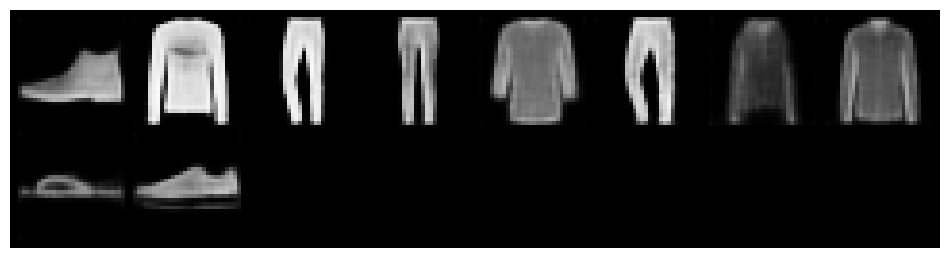

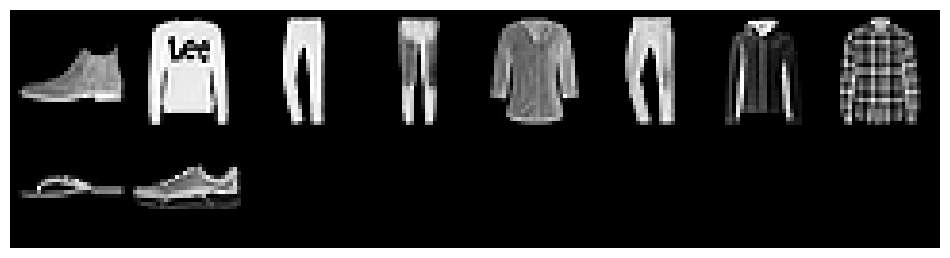


Test set: Average loss: 39.2247

Train Epoch: 92 [0/60000 (0%)]	Loss: 0.054036
Train Epoch: 92 [12800/60000 (21%)]	Loss: 0.052550
Train Epoch: 92 [25600/60000 (43%)]	Loss: 0.051099
Train Epoch: 92 [38400/60000 (64%)]	Loss: 0.050025
Train Epoch: 92 [51200/60000 (85%)]	Loss: 0.045068

Test set: Average loss: 39.4989

Train Epoch: 93 [0/60000 (0%)]	Loss: 0.051080
Train Epoch: 93 [12800/60000 (21%)]	Loss: 0.043897
Train Epoch: 93 [25600/60000 (43%)]	Loss: 0.048283
Train Epoch: 93 [38400/60000 (64%)]	Loss: 0.051931
Train Epoch: 93 [51200/60000 (85%)]	Loss: 0.052089

Test set: Average loss: 39.2613

Train Epoch: 94 [0/60000 (0%)]	Loss: 0.055975
Train Epoch: 94 [12800/60000 (21%)]	Loss: 0.047213
Train Epoch: 94 [25600/60000 (43%)]	Loss: 0.046725
Train Epoch: 94 [38400/60000 (64%)]	Loss: 0.049922
Train Epoch: 94 [51200/60000 (85%)]	Loss: 0.045153

Test set: Average loss: 39.3695

Train Epoch: 95 [0/60000 (0%)]	Loss: 0.042247
Train Epoch: 95 [12800/60000 (21%)]	Loss: 0.041793
Train Epoch: 95 [

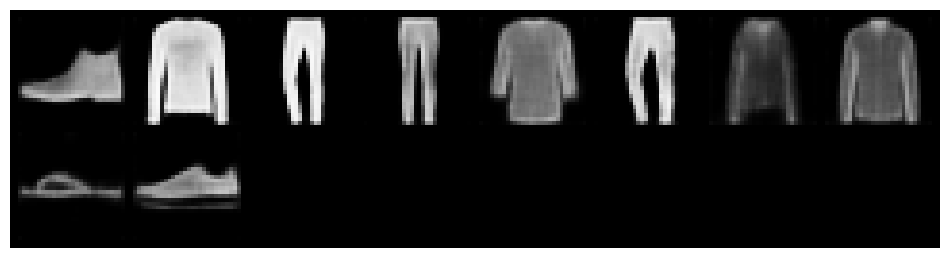

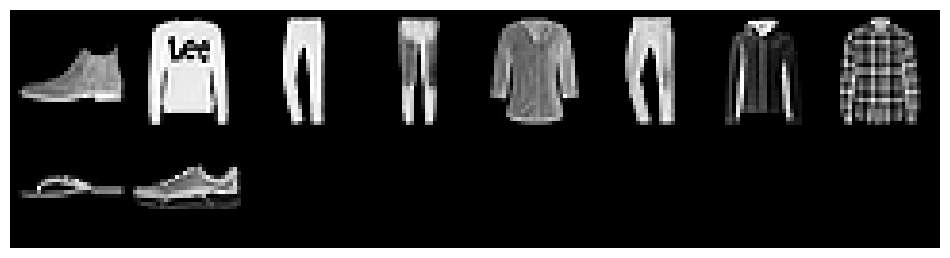


Test set: Average loss: 39.0710

The best(lowest) achieved loss: 38.901



In [134]:
best_loss = 1000. # something large
# run training
args.is_noisy = False
test(show_plot=True)
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test_loss = test(show_plot=epoch%10 == 1)
    if test_loss < best_loss:
        best_loss = test_loss
        if args.is_noisy:
            torch.save(model.state_dict(), 'best_conv_denoising_autoencoder.pth')
        else:
            torch.save(model.state_dict(), 'best_conv_autoencoder.pth')
# 
print('The best(lowest) achieved loss: {:.3f}\n'.format(best_loss))